In [3]:
using OrdinaryDiffEq

function f(u, p, t)
    return [p[1] * u[1] - p[2] * u[1] * u[2], -p[3] * u[2] + p[4] * u[1] * u[2]]
end

p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0, 1.0]
prob_oop = ODEProblem{false}(f, u0, (0.0, 3.0), p)
true_sol = solve(prob_oop, Tsit5(), saveat=0.01)

retcode: Success
Interpolation: 1st order linear
t: 301-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0
u: 301-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0051122697054304, 0.9802235489841001]
 [1.0104482482084793, 0.960888402913325]
 [1.0160067852516195, 0.9419859539931973]
 [1.0217868581271057, 0.9235077034160883]
 [1.0277875716769742, 0.9054452613612183]
 [1.034008158293044, 0.8877903469946546]
 [1.0404479779169147, 0.8705347884693151]
 [1.0471065141055134, 0.8536705240234226]
 [1.0539833005834183, 0.8371896275033469]
 ⋮
 [1.0163110485798996, 2.24060823429365]
 [1.0090249094070312, 2.1965201574788167]
 [1.0022263010549455, 2.15315467122958]
 [0.9958993615105561, 2.110513230272754]
 [0.9900294369696907, 2.0685953916533597]
 [0.9846030818370904, 2.02739881473463]
 [0.9796080587264039, 1.986919261197954]
 [0.9750333384601948, 1.9471505950429426]
 [0.970869100069937, 1.908084782587384]

In [4]:
using ModelingToolkit
using Sophon, IntervalSets
using Optimization, OptimizationOptimJL

@parameters t
@variables x(..), y(..)

Dₜ = Differential(t)

eqs = [Dₜ(x(t)) ~ p[1] * x(t) - p[2] * x(t) * y(t),
      Dₜ(y(t)) ~ -p[3] * y(t) + p[4] * x(t) * y(t)]

domain = [t ∈ 0 .. 3.0]

bcs = [x(0.0) ~ 1.0, y(0.0) ~ 1.0]

@named lotka_volterra = PDESystem(eqs, bcs, domain, [t], [x(t), y(t)])

PDESystem
Equations: Equation[Differential(t)(x(t)) ~ 1.5x(t) - x(t)*y(t), Differential(t)(y(t)) ~ x(t)*y(t) - 3.0y(t)]
Boundary Conditions: Equation[x(0.0) ~ 1.0, y(0.0) ~ 1.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..3.0)]
Dependent Variables: Num[x(t), y(t)]
Independent Variables: Num[t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [6]:
pinn = PINN(x = FullyConnected(1, 1, sin; hidden_dims=6, num_layers=2),
            y = FullyConnected(1, 1, sin; hidden_dims=6, num_layers=2))

sampler = BetaRandomSampler(200, 1)
strategy = NonAdaptiveTraining(1,50)

prob = Sophon.discretize(lotka_volterra, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(x = (layer_1 = (weight = [-1.9681679010391235; 0.25779038667678833; … ; 2.3228445053100586; -1.5243279933929443;;], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.5253913998603821 0.2719012200832367 … 0.24492131173610687 0.736621081829071; -0.33588728308677673 0.8835613131523132 … 0.3920764625072479 -0.6995512843132019; … ; 0.08107470721006393 -0.07664989680051804 … 0.11404215544462204 -0.31778618693351746; -0.48167261481285095 -0.642677366733551 … 0.6751618981361389 0.8784815669059753], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.9659270644187927 0.9165356755256653 … 0.9677667021751404 -0.8049258589744568], bias = [0.0;;])), y = (layer_1 = (weight = [-1.6245161294937134; -1.0071942806243896; … ; 1.34771728515625; -0.49877870082855225;;], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.4435829818248749 -0.6285753846168518 … -0.21670447289943695 -0.8953656554222107; 0.193114742636680

In [7]:
function callback(p, l)
    println("Loss: $l")
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 121.03127104121974
Loss: 76.22408770490595
Loss: 61.15535125111951
Loss: 31.771655896412273
Loss: 24.058061884189687
Loss: 14.324746060833569
Loss: 10.671477952952468
Loss: 8.578155688996345


Loss: 6.25900020476949
Loss: 4.312318410717028
Loss: 2.9728694587334656
Loss: 2.1842930553390554
Loss: 1.1793606591928718
Loss: 0.6464368178015313
Loss: 0.5607849815068635
Loss: 0.42756058909252986
Loss: 0.4011236412689655
Loss: 0.3141766185699511
Loss: 0.2274139032737991
Loss: 0.21576310881927832
Loss: 0.18544223202064888


Loss: 0.172935276106646
Loss: 0.16092716489416892
Loss: 0.14074514832947266
Loss: 0.1371333549513286
Loss: 0.13050512023293326
Loss: 0.1266673458293586
Loss: 0.11884696887144255
Loss: 0.11169180934853491
Loss: 0.1097112133679149
Loss: 0.1064189704447547
Loss: 0.10376909405019963
Loss: 0.10102247204827523
Loss: 0.0992335582639994
Loss: 0.09606202990485671
Loss: 0.09220822082746118
Loss: 0.08770411471983777
Loss: 0.08191415803447781


Loss: 0.0770770037446468
Loss: 0.07332496965059097
Loss: 0.07201311613031129
Loss: 0.06911823538649996
Loss: 0.06779045451438091
Loss: 0.06503701993433357
Loss: 0.06228189848796928
Loss: 0.06035536004335103
Loss: 0.05863129158625562
Loss: 0.05688611858687183
Loss: 0.05560990886101633
Loss: 0.05479403895578642
Loss: 0.05318823229993989
Loss: 0.052378446806744625
Loss: 0.051015041939819275
Loss: 0.04996126503504074
Loss: 0.048294470952494874
Loss: 0.04654393694667326
Loss: 0.0461450976836346


Loss: 0.04496280902011022
Loss: 0.044289072662588864
Loss: 0.04349148202444214
Loss: 0.0429905623740081
Loss: 0.042217232715108896
Loss: 0.04140389454338409
Loss: 0.03971401332348705
Loss: 0.038122061092408746
Loss: 0.0366671121370398
Loss: 0.034238279605365705
Loss: 0.03358020991720935
Loss: 0.032961551440696235
Loss: 0.03197320274920546
Loss: 0.03050140182229005
Loss: 0.02899794552849551
Loss: 0.027817877487637338
Loss: 0.026501219967278968
Loss: 0.02549324454477011
Loss: 0.024806789848468788


Loss: 0.02408618462856442
Loss: 0.0234224133094873
Loss: 0.022687886221449637
Loss: 0.021776749265847006
Loss: 0.02074543762656393
Loss: 0.019997125700928466
Loss: 0.019383334646084112
Loss: 0.018594078537425167
Loss: 0.018020862458971748
Loss: 0.01761058969716166
Loss: 0.016812209523304884
Loss: 0.016291709765649368
Loss: 0.01574438399808314
Loss: 0.015179999317687987
Loss: 0.014913552678141786
Loss: 0.01462490456655765
Loss: 0.014255254818172797
Loss: 0.014037447118267819
Loss: 0.013637685930223442


Loss: 0.013430805071986688
Loss: 0.013146990904835787
Loss: 0.012885141014732478
Loss: 0.012706910559463663
Loss: 0.012300687928745245
Loss: 0.011840076343753331
Loss: 0.011399778420664593
Loss: 0.01118626722128455
Loss: 0.010948652308155274
Loss: 0.010723636349025496
Loss: 0.010331653204492582
Loss: 0.00995317057102624
Loss: 0.009717217049743909
Loss: 0.00933242029701645
Loss: 0.009004334976417823
Loss: 0.008740302916082954
Loss: 0.008462306623174733
Loss: 0.008249324920194675


Loss: 0.008041159589174125
Loss: 0.007828038922449423
Loss: 0.007651666237736461
Loss: 0.007369507875457886
Loss: 0.007215424237512067
Loss: 0.007084086754881026
Loss: 0.006936451343451119
Loss: 0.0067991710861030445
Loss: 0.006678272524971336
Loss: 0.006527527544255662
Loss: 0.006370886510966538
Loss: 0.006255048125394878
Loss: 0.00620048748309574
Loss: 0.0061374237249476335
Loss: 0.006069015422910574
Loss: 0.005948892850309368
Loss: 0.005820636257099978
Loss: 0.005674973245270535
Loss: 0.0055772249986813256
Loss: 0.0054928851820860896
Loss: 0.005403083992412587


Loss: 0.005345866357544773
Loss: 0.005263549941526324
Loss: 0.005206290718048152
Loss: 0.005139116712697449
Loss: 0.005045024944223528
Loss: 0.004982904072010652
Loss: 0.004907862272753178
Loss: 0.004835463195252848
Loss: 0.00477090222303603
Loss: 0.004649079454061004
Loss: 0.00457581459446313
Loss: 0.0045514833951642965
Loss: 0.004515956887659109
Loss: 0.004464599212788426
Loss: 0.004417129246845253
Loss: 0.004355296610370722
Loss: 0.0043276739272196324
Loss: 0.004279037792412139


Loss: 0.004203316277654643
Loss: 0.00411597984085201
Loss: 0.004058469672885029
Loss: 0.004011934870232381
Loss: 0.003979171116166557
Loss: 0.003943136415134362
Loss: 0.003905627302900106
Loss: 0.0038824428112285495
Loss: 0.003866111698722553
Loss: 0.0038277906132119345
Loss: 0.0037793480069882937
Loss: 0.0036543303881633473
Loss: 0.003577085631237563
Loss: 0.00343453274298679
Loss: 0.0033120430222873176
Loss: 0.003213004768356444


Loss: 0.0030920346029271366
Loss: 0.0030234933341930365
Loss: 0.002982709332924616
Loss: 0.002836580445699736
Loss: 0.0027469484146455565
Loss: 0.002703800515969857
Loss: 0.0026376942435161407
Loss: 0.002585830827527303
Loss: 0.0025277803281181545
Loss: 0.0024892627387717546
Loss: 0.0024191811664576275
Loss: 0.0023880316785195362
Loss: 0.0023454768912235763
Loss: 0.0022931671543399935
Loss: 0.0022433943607253677
Loss: 0.002088120141001443
Loss: 0.0020226553420625683
Loss: 0.0019097086491810435
Loss: 0.001846967016869817


Loss: 0.0017969659169179506
Loss: 0.0017497967633965333
Loss: 0.0017291682928723751
Loss: 0.0016875362288168985
Loss: 0.0016473985515883527
Loss: 0.0016090662447103094
Loss: 0.0015836318088451927
Loss: 0.0015423881582487867
Loss: 0.0015118054532272036
Loss: 0.0014760233801971614
Loss: 0.001442279041010917
Loss: 0.001409936097904909
Loss: 0.001378499524502514
Loss: 0.001350048001091251
Loss: 0.0013304251641108194
Loss: 0.0013162758199060643
Loss: 0.0013082924776421734
Loss: 0.0013032498991916444
Loss: 0.0012963863789737977


Loss: 0.0012883585924523897
Loss: 0.0012843212725267162
Loss: 0.0012811427048740303
Loss: 0.0012759733476472095
Loss: 0.0012647549640291637
Loss: 0.0012531648484768137
Loss: 0.0012349142667669674
Loss: 0.0012175338844873681
Loss: 0.0011751159081332871
Loss: 0.0011618759924672773
Loss: 0.0011061453749644618
Loss: 0.0010951235244301217
Loss: 0.0010593909091430973
Loss: 0.0010471047988714363
Loss: 0.0010319583785299597
Loss: 0.0010135908001457719
Loss: 0.0009875839189974979
Loss: 0.0009600496720868515


Loss: 0.0009379625351367421
Loss: 0.0009021663260058491
Loss: 0.0008879638703059604
Loss: 0.0008611840466896346
Loss: 0.0008376313916178903
Loss: 0.0008165361042568192
Loss: 0.0007939295107381456
Loss: 0.0007760379507902303
Loss: 0.0007495224814740802
Loss: 0.0007384341811715019
Loss: 0.0007028348047050894
Loss: 0.0006890914858242296
Loss: 0.0006684315747959727
Loss: 0.0006545381054075052
Loss: 0.0006391787902304336
Loss: 0.0006240152714697823
Loss: 0.0006115832116304131
Loss: 0.0005941654407127316
Loss: 0.0005748092234701169
Loss: 0.0005549996170772591
Loss: 0.000546518241842898
Loss: 0.000538363480509425


Loss: 0.000531433240612718
Loss: 0.0005240395923760775
Loss: 0.0005133540852477561
Loss: 0.0004935663229481545
Loss: 0.00047313466255934533
Loss: 0.000459489471615811
Loss: 0.0004503442524464474
Loss: 0.00044284892286925625
Loss: 0.00043697263584329267
Loss: 0.0004265428780511712
Loss: 0.00041864173944971796
Loss: 0.00041433097056235767
Loss: 0.00041158933931679473
Loss: 0.0004090302967414062
Loss: 0.00040715709936722463


Loss: 0.00040403916563973687
Loss: 0.0003992896059824232
Loss: 0.00038749378177012713
Loss: 0.00037842838127541775
Loss: 0.0003719895773689118
Loss: 0.0003677348960182294
Loss: 0.0003645783219248184
Loss: 0.00036215873311774084
Loss: 0.00036017051149511155
Loss: 0.0003586672507823382
Loss: 0.0003570416137645989
Loss: 0.0003553886059179397
Loss: 0.0003536186490293315
Loss: 0.0003515401056412707


Loss: 0.00034951589448773746
Loss: 0.00034898608523821695
Loss: 0.000348700588552581
Loss: 0.00034823183957989303
Loss: 0.00034711096728337967
Loss: 0.00034585563951805413
Loss: 0.00034498182407590816
Loss: 0.0003439695618008366
Loss: 0.00034171211258690034
Loss: 0.0003398866663742144
Loss: 0.0003381381259086797
Loss: 0.0003357831507775451
Loss: 0.0003336309074046799


Loss: 0.0003316938734442015
Loss: 0.00033043472715010017
Loss: 0.0003293056604255107
Loss: 0.0003283687371410782
Loss: 0.0003275377893800842
Loss: 0.0003250129418887457
Loss: 0.00032000559966099355
Loss: 0.00031241274097984836
Loss: 0.000300400187393703
Loss: 0.00029189437906479963
Loss: 0.0002845071138083764
Loss: 0.0002789671552597652
Loss: 0.000276446962057414
Loss: 0.0002725860878222817


Loss: 0.0002665500119220169
Loss: 0.0002627436804999695
Loss: 0.0002585577371631701
Loss: 0.00025593598575344013
Loss: 0.00025450316222162323
Loss: 0.0002511918166181969
Loss: 0.0002491734247573595
Loss: 0.0002469086253518086
Loss: 0.0002450137868219814
Loss: 0.00024301266888364622
Loss: 0.00024094220332613838
Loss: 0.00023839959967461834
Loss: 0.00023629676202468612
Loss: 0.0002345911203785788
Loss: 0.00023287541792983463
Loss: 0.00023119479440035157
Loss: 0.00022968284501700533
Loss: 0.0002272720328289976
Loss: 0.00022415400873671327


Loss: 0.00022280111973154175
Loss: 0.00022202826051983984
Loss: 0.0002204578372117551
Loss: 0.00021789835442276865
Loss: 0.00021700064891660376
Loss: 0.0002165346444501182
Loss: 0.00021623034678072272
Loss: 0.0002160314880590427
Loss: 0.0002159417355836307
Loss: 0.0002158529470937431
Loss: 0.00021571869047118733
Loss: 0.00021556712479754296
Loss: 0.00021525829769983998
Loss: 0.0002150210600103927
Loss: 0.00021477203940332257
Loss: 0.0002145541062242293


Loss: 0.00021433692580258244
Loss: 0.00021399212956515115
Loss: 0.00021371880392686855
Loss: 0.00021345698415652033
Loss: 0.00021280665943895706
Loss: 0.0002115391170573887
Loss: 0.00021057701276282122
Loss: 0.00020988630238315376
Loss: 0.00020940026642936275
Loss: 0.00020878506094144144
Loss: 0.00020727969034868457
Loss: 0.00020517823251309488
Loss: 0.00020302080852732852
Loss: 0.00020202730002950422
Loss: 0.00020073975640993555
Loss: 0.00019988993770083766


Loss: 0.0001991413501782502
Loss: 0.00019823359608573416
Loss: 0.00019723633979751824
Loss: 0.0001964048552369956
Loss: 0.00019610216694434984
Loss: 0.00019548341616398927
Loss: 0.00019508851532567712
Loss: 0.00019486298067088442
Loss: 0.0001945047618080222
Loss: 0.00019430802145526887
Loss: 0.0001941273055351821
Loss: 0.00019404660934095805
Loss: 0.00019395854530630935
Loss: 0.0001938689845333906
Loss: 0.00019375482475800278
Loss: 0.0001936417475557098
Loss: 0.00019348921285404686


Loss: 0.00019325828116657095
Loss: 0.0001930263127092899
Loss: 0.00019267927898334867
Loss: 0.00019249691534582562
Loss: 0.00019235244097110614
Loss: 0.00019213345772447078
Loss: 0.00019179029123032258
Loss: 0.0001914698264422351
Loss: 0.0001912671805396547
Loss: 0.0001910794152488695
Loss: 0.00019054585057531385
Loss: 0.00018967343163672526
Loss: 0.00018830234328525832


Loss: 0.00018687452331092995
Loss: 0.00018594436727302745
Loss: 0.00018314797680759904
Loss: 0.0001811699222280018
Loss: 0.0001774983103530041
Loss: 0.0001745597568921787
Loss: 0.00017358209510535903
Loss: 0.00017115214708160126
Loss: 0.00017058258044452563
Loss: 0.00016936251080806704
Loss: 0.00016737767985222827
Loss: 0.0001656447083775899
Loss: 0.00016464339253978116
Loss: 0.0001630812722785777
Loss: 0.00016170418768190646
Loss: 0.00016084941821837626
Loss: 0.0001602478224846667
Loss: 0.00015941081913085925
Loss: 0.00015779542118342748


Loss: 0.00015674877105768773
Loss: 0.00015547213365166613
Loss: 0.00015505475839390354
Loss: 0.00015277641724798112
Loss: 0.00015074861337650538
Loss: 0.00014909798773287767
Loss: 0.00014815365401563247
Loss: 0.0001476010772451143
Loss: 0.0001470178933613472
Loss: 0.0001465594284758839
Loss: 0.0001456692078830916
Loss: 0.0001450525852588297
Loss: 0.00014335925289814334
Loss: 0.00014182217535519342
Loss: 0.00013976276317865358
Loss: 0.00013749603285532404
Loss: 0.0001362751920724895
Loss: 0.00013577538728880544
Loss: 0.00013458499112037518


Loss: 0.00013312172084142923
Loss: 0.00013143951797950124
Loss: 0.00012997072389743083
Loss: 0.00012724553192634456
Loss: 0.00012659350077503934
Loss: 0.00012430595104023152
Loss: 0.00012317317249174053
Loss: 0.00012172322809517495
Loss: 0.00012013249432429202
Loss: 0.00011948652269790711
Loss: 0.00011888108592030223
Loss: 0.0001184009154256292
Loss: 0.00011761498044807177
Loss: 0.0001169740029898272
Loss: 0.00011633868732068845
Loss: 0.00011542943425469069
Loss: 0.00011367626772161864
Loss: 0.0001114019472955089
Loss: 0.00010968886072957359
Loss: 0.00010883225775936705
Loss: 0.00010652978171172973


Loss: 0.00010602381964405182
Loss: 0.00010314135749694898
Loss: 0.00010128289657529464
Loss: 9.955191677446987e-5
Loss: 9.904156741782254e-5
Loss: 9.757967524387708e-5
Loss: 9.63298248664015e-5
Loss: 9.497665030109114e-5
Loss: 9.377709177040122e-5
Loss: 9.286375284421058e-5
Loss: 9.159871605564174e-5
Loss: 9.090550098174126e-5
Loss: 9.003079285521082e-5
Loss: 8.908084113198376e-5
Loss: 8.799737253581767e-5
Loss: 8.618178089787381e-5
Loss: 8.434632579857774e-5
Loss: 8.344455234305225e-5
Loss: 8.311869890849988e-5
Loss: 8.296638336375721e-5


Loss: 8.260037682623955e-5
Loss: 8.237545780936908e-5
Loss: 8.202589420423005e-5
Loss: 8.182803024056133e-5
Loss: 8.167265898027112e-5
Loss: 8.156059828764435e-5
Loss: 8.129717121275124e-5
Loss: 8.101813576083969e-5
Loss: 8.075074330225068e-5
Loss: 8.062405978309936e-5
Loss: 8.054611984195754e-5
Loss: 8.035238470875536e-5
Loss: 7.991373241116361e-5
Loss: 7.961181687107085e-5
Loss: 7.937038243606225e-5
Loss: 7.910909401725952e-5


Loss: 7.883949670731872e-5
Loss: 7.868385775674175e-5
Loss: 7.857409345546386e-5
Loss: 7.84386343609633e-5
Loss: 7.829044064095151e-5
Loss: 7.816054570210687e-5
Loss: 7.795597625394937e-5
Loss: 7.754643201655826e-5
Loss: 7.673528638819192e-5
Loss: 7.578122793143926e-5
Loss: 7.54594113233575e-5
Loss: 7.502357844436991e-5
Loss: 7.47236144817393e-5
Loss: 7.457181090079221e-5
Loss: 7.431186650253502e-5


Loss: 7.375016142374319e-5
Loss: 7.313913092987812e-5
Loss: 7.281171394304832e-5
Loss: 7.262763676294888e-5
Loss: 7.242545200557149e-5
Loss: 7.200687016924531e-5
Loss: 7.14878967136888e-5
Loss: 7.095005124958188e-5
Loss: 7.053832615668955e-5
Loss: 7.020363503398008e-5
Loss: 7.003142853973471e-5
Loss: 6.992078404164202e-5
Loss: 6.978612027624117e-5
Loss: 6.947008938970214e-5
Loss: 6.9080116597293e-5
Loss: 6.871268626053646e-5


Loss: 6.851225491248996e-5
Loss: 6.837300188750208e-5
Loss: 6.825475821525514e-5
Loss: 6.812820520220857e-5
Loss: 6.802031147636283e-5
Loss: 6.791899101865727e-5
Loss: 6.775139173220175e-5
Loss: 6.728477079609161e-5
Loss: 6.68909556633853e-5
Loss: 6.664049855716957e-5
Loss: 6.647698591834058e-5
Loss: 6.633675533722247e-5
Loss: 6.619350944630741e-5


Loss: 6.602803558312316e-5
Loss: 6.583773095113127e-5
Loss: 6.569077998896077e-5
Loss: 6.560474494454064e-5
Loss: 6.555277426299889e-5
Loss: 6.550209083325838e-5
Loss: 6.543974454757886e-5
Loss: 6.529992985935924e-5
Loss: 6.508193010322494e-5
Loss: 6.479659761389967e-5
Loss: 6.440297404406754e-5
Loss: 6.410737040718865e-5
Loss: 6.393244675421493e-5
Loss: 6.370156316982393e-5
Loss: 6.36004755208999e-5


Loss: 6.356122167185636e-5
Loss: 6.353135019928294e-5
Loss: 6.350858424961906e-5
Loss: 6.348592412514103e-5
Loss: 6.345131377173577e-5
Loss: 6.333889870151922e-5
Loss: 6.307681950356767e-5
Loss: 6.251595397085734e-5
Loss: 6.200429246238107e-5
Loss: 6.166755127323979e-5
Loss: 6.155450782292924e-5
Loss: 6.148176081546895e-5
Loss: 6.14221734015095e-5
Loss: 6.140551573717962e-5
Loss: 6.135836204145262e-5


Loss: 6.131372076107825e-5
Loss: 6.12406815058712e-5
Loss: 6.113526347975558e-5
Loss: 6.104877237507066e-5
Loss: 6.099447807161701e-5
Loss: 6.097292532152587e-5
Loss: 6.096373482015603e-5
Loss: 6.0954979081313216e-5
Loss: 6.0918720288648294e-5
Loss: 6.08674700794222e-5
Loss: 6.0790622218235925e-5
Loss: 6.0626085737098694e-5
Loss: 6.038039705053268e-5
Loss: 6.002929200226517e-5
Loss: 5.9740685109803837e-5


Loss: 5.909041315634718e-5
Loss: 5.8811181565647564e-5
Loss: 5.808077703095306e-5
Loss: 5.786729283848903e-5
Loss: 5.726073223765742e-5
Loss: 5.7024441598068966e-5
Loss: 5.667514825731568e-5
Loss: 5.6076317813454024e-5
Loss: 5.564987199033325e-5
Loss: 5.527946673052951e-5
Loss: 5.481639276645957e-5
Loss: 5.461679287398864e-5
Loss: 5.427134053511556e-5
Loss: 5.410089795469505e-5
Loss: 5.395903465016408e-5
Loss: 5.3821280031617197e-5
Loss: 5.369118560334453e-5
Loss: 5.35814401821417e-5
Loss: 5.3505376482228385e-5
Loss: 5.343530863164486e-5


Loss: 5.33459643129201e-5
Loss: 5.328251403771739e-5
Loss: 5.3212127716276877e-5
Loss: 5.31223628950483e-5
Loss: 5.306257187911485e-5
Loss: 5.300765122928826e-5
Loss: 5.294762700360448e-5
Loss: 5.284598029684874e-5
Loss: 5.2758767165478766e-5
Loss: 5.272876522255554e-5
Loss: 5.271083633688933e-5
Loss: 5.2693879470955926e-5
Loss: 5.2673528703221626e-5
Loss: 5.265374068587335e-5
Loss: 5.262466766916065e-5
Loss: 5.2547591682125675e-5


Loss: 5.24495632683385e-5
Loss: 5.2402190312185963e-5
Loss: 5.2371987692620234e-5
Loss: 5.232883952464417e-5
Loss: 5.225521398725629e-5
Loss: 5.208791987040405e-5
Loss: 5.187779682559376e-5
Loss: 5.151461181048437e-5
Loss: 5.1237557349438815e-5
Loss: 5.115746122950886e-5
Loss: 5.100451424695101e-5
Loss: 5.0871518599060235e-5
Loss: 5.067143221190854e-5
Loss: 5.029264947674115e-5


Loss: 4.986188916329296e-5
Loss: 4.973479371117156e-5
Loss: 4.943622722145444e-5
Loss: 4.9129801868198025e-5
Loss: 4.861595764145684e-5
Loss: 4.8371138722760596e-5
Loss: 4.812806301507885e-5
Loss: 4.750732931243057e-5
Loss: 4.714775557156606e-5
Loss: 4.6719937579017283e-5
Loss: 4.6367593220174364e-5
Loss: 4.606974264512146e-5
Loss: 4.5834913722734155e-5
Loss: 4.566040992233209e-5
Loss: 4.5516418778653894e-5
Loss: 4.538035244739181e-5
Loss: 4.531337746207616e-5
Loss: 4.527899792463942e-5
Loss: 4.525076520610937e-5


Loss: 4.5222507525917744e-5
Loss: 4.519180491795904e-5
Loss: 4.5134068425932575e-5
Loss: 4.507679589725813e-5
Loss: 4.501231035619826e-5
Loss: 4.4914433919445064e-5
Loss: 4.4775981203777575e-5
Loss: 4.467347135643482e-5
Loss: 4.4616492873469476e-5
Loss: 4.457469999581684e-5
Loss: 4.449601320215865e-5
Loss: 4.4388105565088066e-5
Loss: 4.414727313838989e-5
Loss: 4.395036618574242e-5
Loss: 4.383428060452269e-5
Loss: 4.3622214293748345e-5


Loss: 4.3437128280366673e-5
Loss: 4.311078523598921e-5
Loss: 4.299424420580203e-5
Loss: 4.2801467557183114e-5
Loss: 4.2643891462885015e-5
Loss: 4.2493194726930254e-5
Loss: 4.237500683281045e-5
Loss: 4.23048713383772e-5
Loss: 4.225306839670162e-5
Loss: 4.221899521198689e-5
Loss: 4.2198201924165144e-5
Loss: 4.215861940602737e-5
Loss: 4.2112492030188293e-5
Loss: 4.203917530936702e-5
Loss: 4.1931443540275995e-5
Loss: 4.177817930877438e-5
Loss: 4.157105974625439e-5
Loss: 4.1430262334901064e-5


Loss: 4.110943263684376e-5
Loss: 4.083622891226771e-5
Loss: 4.06586859408852e-5
Loss: 4.0520908785833864e-5
Loss: 4.0408830130334654e-5
Loss: 4.033805383292138e-5
Loss: 4.028761057050734e-5
Loss: 4.0244426783025474e-5
Loss: 4.018832287265077e-5
Loss: 4.010470116541889e-5
Loss: 3.997391308296446e-5
Loss: 3.9811419340292236e-5
Loss: 3.952501058395705e-5
Loss: 3.9235204360508055e-5
Loss: 3.901654770999245e-5
Loss: 3.874583181871628e-5
Loss: 3.8497232818814474e-5
Loss: 3.822596315212625e-5


Loss: 3.795356247206512e-5
Loss: 3.774014297235433e-5
Loss: 3.744077896954922e-5
Loss: 3.707935124208069e-5
Loss: 3.668355428823424e-5
Loss: 3.606334415620707e-5
Loss: 3.554683890269615e-5
Loss: 3.514851878317254e-5
Loss: 3.4961006233404736e-5
Loss: 3.463110985208451e-5
Loss: 3.44463010029103e-5
Loss: 3.415661450564729e-5
Loss: 3.394122493721986e-5
Loss: 3.37031134866905e-5
Loss: 3.354177234475923e-5
Loss: 3.342200896688624e-5
Loss: 3.3262507136090325e-5
Loss: 3.307810160867445e-5
Loss: 3.289819618159062e-5


Loss: 3.265027700595502e-5
Loss: 3.256239993148882e-5
Loss: 3.247910299308569e-5
Loss: 3.2400722828633294e-5
Loss: 3.224618402270015e-5
Loss: 3.211426807545475e-5
Loss: 3.185521611055382e-5
Loss: 3.168564569734048e-5
Loss: 3.1387410275015854e-5
Loss: 3.1162779223367306e-5
Loss: 3.08350075314668e-5
Loss: 3.06200760226014e-5
Loss: 3.043157285448507e-5
Loss: 3.013783166810796e-5
Loss: 2.987027899353065e-5
Loss: 2.9727784111907533e-5
Loss: 2.9524954098599985e-5
Loss: 2.9354763094203976e-5


Loss: 2.9226949577423472e-5
Loss: 2.8940421915103407e-5
Loss: 2.854107757281911e-5
Loss: 2.792507842661545e-5
Loss: 2.724828381659859e-5
Loss: 2.6755649262228884e-5
Loss: 2.6251078418282633e-5
Loss: 2.5673751666899913e-5
Loss: 2.541708111188198e-5
Loss: 2.5187526611816062e-5
Loss: 2.4883749967986932e-5
Loss: 2.4691133388181903e-5
Loss: 2.450692204328263e-5
Loss: 2.4191552308967234e-5
Loss: 2.385076488598673e-5
Loss: 2.3432874857329916e-5
Loss: 2.312168916871243e-5


Loss: 2.3018037769022073e-5
Loss: 2.282729003798382e-5
Loss: 2.2644759742190423e-5
Loss: 2.244914738480403e-5
Loss: 2.2308010790993462e-5
Loss: 2.217001531203956e-5
Loss: 2.2050528054883654e-5
Loss: 2.1912853841032254e-5
Loss: 2.1633576822136802e-5
Loss: 2.1356109263715538e-5
Loss: 2.1287598984870267e-5
Loss: 2.1031477813659175e-5
Loss: 2.0851098146375037e-5
Loss: 2.059063426079936e-5
Loss: 2.0261293856027722e-5
Loss: 2.0060819393515557e-5
Loss: 1.9737373414877423e-5
Loss: 1.9398684504986577e-5


Loss: 1.9055413214351936e-5
Loss: 1.8798133022095474e-5
Loss: 1.86254705640565e-5
Loss: 1.8512704332734336e-5
Loss: 1.844167189381497e-5
Loss: 1.8370917126260456e-5
Loss: 1.8293330593704985e-5
Loss: 1.8184833872187243e-5
Loss: 1.8106096934487048e-5
Loss: 1.8028383630435986e-5
Loss: 1.7941319235374744e-5
Loss: 1.773059314010791e-5
Loss: 1.752589217541881e-5


Loss: 1.745340084790512e-5
Loss: 1.7423690941309256e-5
Loss: 1.73850728542096e-5
Loss: 1.7278054848146207e-5
Loss: 1.7187020509794614e-5
Loss: 1.7115581052968688e-5
Loss: 1.7035931404513464e-5
Loss: 1.6949825849199485e-5
Loss: 1.6843856930741967e-5
Loss: 1.6770819364200377e-5
Loss: 1.6702844201272046e-5
Loss: 1.6674420086161474e-5
Loss: 1.6664708999161852e-5
Loss: 1.6659866552485764e-5


Loss: 1.664781344286292e-5
Loss: 1.6632758754493574e-5
Loss: 1.662243341450038e-5
Loss: 1.6615425696938213e-5
Loss: 1.6602863318261973e-5
Loss: 1.659047486575924e-5
Loss: 1.658429266267798e-5
Loss: 1.6570757089911588e-5
Loss: 1.6533599547298065e-5
Loss: 1.642960702444068e-5
Loss: 1.6340034834185733e-5
Loss: 1.6246064394375855e-5
Loss: 1.6172115149433978e-5
Loss: 1.613836271352961e-5


Loss: 1.6129460179004495e-5
Loss: 1.6124051397267254e-5
Loss: 1.6121278832364377e-5
Loss: 1.611859385831878e-5
Loss: 1.611726434404443e-5
Loss: 1.61150731692213e-5
Loss: 1.6107131691477852e-5
Loss: 1.6089171877006278e-5
Loss: 1.6057247303790882e-5
Loss: 1.5994054383211746e-5
Loss: 1.594927319858295e-5
Loss: 1.58672190446285e-5
Loss: 1.5818758128080045e-5
Loss: 1.5786087688965594e-5
Loss: 1.5766888195458182e-5
Loss: 1.574871401786552e-5
Loss: 1.572995197632328e-5


Loss: 1.5711339112080185e-5
Loss: 1.5698364616587846e-5
Loss: 1.568991935244792e-5
Loss: 1.568620672230355e-5
Loss: 1.568466456491405e-5
Loss: 1.5683815203336762e-5
Loss: 1.568288861794946e-5
Loss: 1.5680699183252764e-5
Loss: 1.5676925978868696e-5
Loss: 1.5671861030822717e-5
Loss: 1.5666923394357175e-5
Loss: 1.56605326444779e-5
Loss: 1.565553969785805e-5
Loss: 1.565120776979401e-5
Loss: 1.564739829144727e-5


Loss: 1.564168261284261e-5
Loss: 1.5636297446940146e-5
Loss: 1.5632004058572237e-5
Loss: 1.562331944299148e-5
Loss: 1.5613626578180394e-5
Loss: 1.5590744877775012e-5
Loss: 1.5578145977776042e-5
Loss: 1.5562542453804837e-5
Loss: 1.5544002330410437e-5
Loss: 1.551048887327487e-5
Loss: 1.5457030246303408e-5
Loss: 1.5439381427165307e-5
Loss: 1.537304721453078e-5
Loss: 1.53503264910339e-5
Loss: 1.5304985149975104e-5
Loss: 1.5256485177679895e-5


Loss: 1.5184547922944906e-5
Loss: 1.5031843423390606e-5
Loss: 1.4977636485980573e-5
Loss: 1.4872496735370858e-5
Loss: 1.481480531954578e-5
Loss: 1.4675838841562717e-5
Loss: 1.4593925914904236e-5
Loss: 1.4468510531147901e-5
Loss: 1.4446666121901811e-5
Loss: 1.4369058508411523e-5
Loss: 1.431417219825084e-5
Loss: 1.4203547767155402e-5
Loss: 1.4161082012114035e-5
Loss: 1.4095159585468605e-5
Loss: 1.405448275952547e-5
Loss: 1.4037743521078288e-5
Loss: 1.39960060996608e-5
Loss: 1.3973178072829457e-5
Loss: 1.394022204417175e-5
Loss: 1.3916959763367212e-5


Loss: 1.3885537415932448e-5
Loss: 1.3858055417102612e-5
Loss: 1.382598948832712e-5
Loss: 1.3798847488563174e-5
Loss: 1.376423373766894e-5
Loss: 1.3707118989155349e-5
Loss: 1.367927811707573e-5
Loss: 1.3645215836592928e-5
Loss: 1.3631952942867381e-5
Loss: 1.3615372276694952e-5
Loss: 1.3603654654887893e-5
Loss: 1.3591040921870702e-5
Loss: 1.3583355466813725e-5
Loss: 1.3578859912634493e-5
Loss: 1.35760892150337e-5
Loss: 1.3572082249302387e-5


Loss: 1.3569234347097153e-5
Loss: 1.3561808876660003e-5
Loss: 1.3543750303075116e-5
Loss: 1.3525496349555595e-5
Loss: 1.3515544606741342e-5
Loss: 1.350617615473608e-5
Loss: 1.3493496519044525e-5
Loss: 1.3485677217988871e-5
Loss: 1.347414920810191e-5
Loss: 1.3457676581046361e-5
Loss: 1.3433959544508093e-5
Loss: 1.3373672235499448e-5
Loss: 1.3319505245106358e-5
Loss: 1.3283486545767866e-5


Loss: 1.324803254238854e-5
Loss: 1.3180875326495313e-5
Loss: 1.309992927255657e-5
Loss: 1.3015733622858793e-5
Loss: 1.2945840433165627e-5
Loss: 1.2881062503246791e-5
Loss: 1.2825702217931811e-5
Loss: 1.2753360628054867e-5
Loss: 1.2683450717215405e-5
Loss: 1.2615410982692545e-5
Loss: 1.2524598163531308e-5
Loss: 1.2467683410661249e-5
Loss: 1.2349344101843565e-5
Loss: 1.2288204515468798e-5
Loss: 1.222298402977077e-5
Loss: 1.2193815567505969e-5
Loss: 1.2179900398007907e-5
Loss: 1.2167702729848218e-5


Loss: 1.2146316588268771e-5
Loss: 1.2121750956264618e-5
Loss: 1.2104734713008629e-5
Loss: 1.2089505823632355e-5
Loss: 1.207536708928416e-5
Loss: 1.2061757045661018e-5
Loss: 1.2042841790215903e-5
Loss: 1.201003584732462e-5
Loss: 1.1963848374432007e-5
Loss: 1.1908105483396698e-5
Loss: 1.178409019897762e-5
Loss: 1.1697667411406094e-5
Loss: 1.1641192203692223e-5
Loss: 1.1608028470907164e-5
Loss: 1.1571837866212448e-5
Loss: 1.152349196216683e-5


Loss: 1.1448200872576037e-5
Loss: 1.1369046057260039e-5
Loss: 1.129053612820258e-5
Loss: 1.1206245585287604e-5
Loss: 1.1166825464784035e-5
Loss: 1.1114191921209411e-5
Loss: 1.1068202993120808e-5
Loss: 1.0994827135874495e-5
Loss: 1.0924812449502984e-5
Loss: 1.0839743141040601e-5
Loss: 1.0747521230813618e-5
Loss: 1.0687780023379481e-5
Loss: 1.064904797633577e-5
Loss: 1.0630664269291767e-5
Loss: 1.0617275371572951e-5
Loss: 1.0612517406454672e-5
Loss: 1.0604774015133854e-5
Loss: 1.0594455479779865e-5


Loss: 1.0585818884399535e-5
Loss: 1.057363617949051e-5
Loss: 1.0541687404973447e-5
Loss: 1.0430124096726684e-5
Loss: 1.022536244720485e-5
Loss: 9.99895450074851e-6
Loss: 9.911717161122348e-6
Loss: 9.808571063344771e-6
Loss: 9.743343383766166e-6
Loss: 9.724089493011555e-6
Loss: 9.695600213889184e-6
Loss: 9.674637970761274e-6
Loss: 9.636167129117836e-6
Loss: 9.598620525110604e-6


Loss: 9.562535547961307e-6
Loss: 9.537016010301739e-6
Loss: 9.52726438299791e-6
Loss: 9.505569131629279e-6
Loss: 9.463547662559505e-6
Loss: 9.395966478550027e-6
Loss: 9.303092858668636e-6
Loss: 9.25103099755763e-6
Loss: 9.176894217405536e-6
Loss: 9.143459039248565e-6
Loss: 9.080495890382118e-6
Loss: 9.027341996463149e-6
Loss: 8.945700342980093e-6
Loss: 8.880961230502554e-6
Loss: 8.841489665625937e-6
Loss: 8.791179677464961e-6
Loss: 8.724449935733836e-6


Loss: 8.65366976231866e-6
Loss: 8.59372511185451e-6
Loss: 8.528739628896204e-6
Loss: 8.491409113394235e-6
Loss: 8.457395823833898e-6
Loss: 8.415097684386059e-6
Loss: 8.364368153229248e-6
Loss: 8.308491325273786e-6
Loss: 8.273994516385587e-6
Loss: 8.22209501592584e-6
Loss: 8.18370962973208e-6
Loss: 8.138628674723346e-6
Loss: 8.108033905712543e-6


Loss: 8.05076049201971e-6
Loss: 8.012455861034553e-6
Loss: 7.958571342822683e-6
Loss: 7.900283887603264e-6
Loss: 7.84069557187716e-6
Loss: 7.785994755326374e-6
Loss: 7.715935979257964e-6
Loss: 7.660366813545175e-6
Loss: 7.60361103498853e-6
Loss: 7.544771436119001e-6
Loss: 7.50772195218926e-6
Loss: 7.470337320576324e-6
Loss: 7.421978942150924e-6
Loss: 7.389142800210539e-6
Loss: 7.353289572711975e-6
Loss: 7.325911816578112e-6
Loss: 7.30012897249651e-6
Loss: 7.282767416952282e-6
Loss: 7.267447107548506e-6


Loss: 7.259929091993837e-6
Loss: 7.252394643187769e-6
Loss: 7.244229413273844e-6
Loss: 7.231243515487674e-6
Loss: 7.216418881716538e-6
Loss: 7.1710092084210414e-6
Loss: 7.069266825748305e-6
Loss: 6.988241115187782e-6
Loss: 6.949003201512931e-6
Loss: 6.908299764092154e-6
Loss: 6.869027470079603e-6
Loss: 6.8094322049634304e-6
Loss: 6.757355137356438e-6
Loss: 6.698233534409552e-6
Loss: 6.6726532421076825e-6


Loss: 6.64881477944611e-6
Loss: 6.638125956167177e-6
Loss: 6.598536966489513e-6
Loss: 6.5670884999965055e-6
Loss: 6.486708492978087e-6
Loss: 6.453391860874678e-6
Loss: 6.38393476573686e-6
Loss: 6.337904718177815e-6
Loss: 6.251056465680115e-6
Loss: 6.156558853843852e-6
Loss: 6.086493863199104e-6
Loss: 6.053958420539163e-6
Loss: 6.031054366912764e-6
Loss: 5.988344702975064e-6
Loss: 5.951642179120258e-6
Loss: 5.911697902140419e-6
Loss: 5.87408664523389e-6


Loss: 5.818228058675668e-6
Loss: 5.773977306667714e-6
Loss: 5.747503113303742e-6
Loss: 5.718823429501963e-6
Loss: 5.684705904724926e-6
Loss: 5.637307422774218e-6
Loss: 5.560918538778553e-6
Loss: 5.498312142054918e-6
Loss: 5.4181126572246445e-6
Loss: 5.3898732831848925e-6
Loss: 5.334901393421358e-6
Loss: 5.312727829718578e-6
Loss: 5.293069883022288e-6
Loss: 5.24820717661932e-6
Loss: 5.223282721315601e-6
Loss: 5.205123768123462e-6
Loss: 5.164790458894484e-6
Loss: 5.123214664358687e-6


Loss: 5.090199176412439e-6
Loss: 5.065601438598832e-6
Loss: 5.04129206228072e-6
Loss: 5.0149110306137605e-6
Loss: 4.976291119236512e-6
Loss: 4.927430806730347e-6
Loss: 4.8944154368275315e-6
Loss: 4.881377156108737e-6
Loss: 4.8450310043573586e-6
Loss: 4.822731409674236e-6
Loss: 4.783686226873896e-6
Loss: 4.768841728807947e-6
Loss: 4.743123370647671e-6
Loss: 4.71341717537409e-6
Loss: 4.6690192773411485e-6
Loss: 4.6475040122595806e-6


Loss: 4.626081139842566e-6
Loss: 4.613858935642336e-6
Loss: 4.593740520366225e-6
Loss: 4.570563513965172e-6
Loss: 4.539073182062687e-6
Loss: 4.498238362191074e-6
Loss: 4.4739406209321666e-6
Loss: 4.452467184500257e-6
Loss: 4.427578867393455e-6
Loss: 4.384774164609401e-6
Loss: 4.33723624242543e-6
Loss: 4.313281538498656e-6
Loss: 4.2760443233365755e-6
Loss: 4.246124539509841e-6
Loss: 4.2270064175357935e-6
Loss: 4.214471722745349e-6
Loss: 4.198084165828801e-6


Loss: 4.188332437509943e-6
Loss: 4.176276373302439e-6
Loss: 4.167229137520801e-6
Loss: 4.160752154043998e-6
Loss: 4.152035690321195e-6
Loss: 4.143666365586135e-6
Loss: 4.131553878884061e-6
Loss: 4.1218764513383385e-6
Loss: 4.116847179661684e-6
Loss: 4.114948195652226e-6
Loss: 4.113725175176823e-6
Loss: 4.112623248206021e-6
Loss: 4.111221323262458e-6
Loss: 4.1093513764582455e-6
Loss: 4.1067510563014824e-6
Loss: 4.104630399694348e-6
Loss: 4.100889718620704e-6


Loss: 4.087935344488109e-6
Loss: 4.071090341432717e-6
Loss: 4.049460897653702e-6
Loss: 3.997801525270742e-6
Loss: 3.938749631897599e-6
Loss: 3.9021704015454886e-6
Loss: 3.87888949151181e-6
Loss: 3.868701723191087e-6
Loss: 3.856761334679856e-6
Loss: 3.849653707767394e-6
Loss: 3.8430547074713965e-6
Loss: 3.833372795605607e-6
Loss: 3.825970658457094e-6
Loss: 3.819673266533361e-6
Loss: 3.810990575637488e-6


Loss: 3.804523842861789e-6
Loss: 3.796953942223926e-6
Loss: 3.7884458184642384e-6
Loss: 3.773810408276364e-6
Loss: 3.7676115361328724e-6
Loss: 3.7548736821256348e-6
Loss: 3.7449053703789275e-6
Loss: 3.738879750979423e-6
Loss: 3.733776432591923e-6
Loss: 3.7243600650811116e-6
Loss: 3.7098349581652684e-6
Loss: 3.6974974541885165e-6
Loss: 3.6851254034694392e-6
Loss: 3.6788857710958627e-6
Loss: 3.6747373971149815e-6
Loss: 3.672671593134526e-6


Loss: 3.6707642413701177e-6
Loss: 3.6672353333818018e-6
Loss: 3.6572241493436113e-6
Loss: 3.6468111031342663e-6
Loss: 3.638922593209758e-6
Loss: 3.631688598214247e-6
Loss: 3.626500673350364e-6
Loss: 3.62357749544085e-6
Loss: 3.6201375620444895e-6
Loss: 3.617475396713733e-6
Loss: 3.6163634043905424e-6
Loss: 3.6152373908111086e-6
Loss: 3.6142256450840822e-6
Loss: 3.6132561057282926e-6
Loss: 3.612515623143993e-6


Loss: 3.6107001531845435e-6
Loss: 3.609077310301336e-6
Loss: 3.607637168036145e-6
Loss: 3.601320960411004e-6
Loss: 3.5644083853177042e-6
Loss: 3.5358907448183577e-6
Loss: 3.469195475978802e-6
Loss: 3.429017648960203e-6
Loss: 3.415704306911408e-6
Loss: 3.3905619433499333e-6
Loss: 3.354509634823296e-6
Loss: 3.277083156389128e-6
Loss: 3.256897118399269e-6
Loss: 3.2061403829516977e-6
Loss: 3.1870488187283132e-6
Loss: 3.168750347580037e-6


Loss: 3.139167686938156e-6
Loss: 3.124265096666952e-6
Loss: 3.105523218886209e-6
Loss: 3.0951815968431914e-6
Loss: 3.078861828260182e-6
Loss: 3.0679745791944126e-6
Loss: 3.053838298954963e-6
Loss: 3.0383638160381318e-6
Loss: 3.0256983909452964e-6
Loss: 3.005082535854149e-6
Loss: 2.9952855369279428e-6
Loss: 2.9857357190966606e-6
Loss: 2.9809757340871874e-6
Loss: 2.9752180983203704e-6
Loss: 2.9667550720717765e-6
Loss: 2.9589167128078113e-6
Loss: 2.955379424212517e-6
Loss: 2.950602105906895e-6


Loss: 2.9480355595166637e-6
Loss: 2.9418283708332163e-6
Loss: 2.938122885494324e-6
Loss: 2.9351006384708966e-6
Loss: 2.933649635137123e-6
Loss: 2.9317663439770203e-6
Loss: 2.929774613942565e-6
Loss: 2.9287551918279366e-6
Loss: 2.927650528354257e-6
Loss: 2.9261897696718234e-6
Loss: 2.924721895470088e-6
Loss: 2.9233916946286534e-6
Loss: 2.922406518189244e-6
Loss: 2.921776183453927e-6
Loss: 2.9208097424923053e-6
Loss: 2.9189119797261974e-6


Loss: 2.916268696136601e-6
Loss: 2.9118244101135355e-6
Loss: 2.9068598428066793e-6
Loss: 2.903559645379586e-6
Loss: 2.900309126863496e-6
Loss: 2.8974859287263595e-6
Loss: 2.8941159732877453e-6
Loss: 2.8915071614438247e-6
Loss: 2.8890287921375036e-6
Loss: 2.8879747839316226e-6
Loss: 2.8868902550100028e-6
Loss: 2.884407904357997e-6
Loss: 2.8826575711041193e-6


Loss: 2.8814618764654514e-6
Loss: 2.8767589291178597e-6
Loss: 2.87171745171698e-6
Loss: 2.8663488005860096e-6
Loss: 2.859292449490527e-6
Loss: 2.851997894191166e-6
Loss: 2.845422910006602e-6
Loss: 2.8375555123705787e-6
Loss: 2.8314229713262022e-6
Loss: 2.829339309864688e-6
Loss: 2.8223354891736955e-6
Loss: 2.8160022610091482e-6
Loss: 2.8121219221483543e-6
Loss: 2.809513825150262e-6
Loss: 2.806486482470164e-6
Loss: 2.8035163467694004e-6


Loss: 2.801557084767805e-6
Loss: 2.7975073166062424e-6
Loss: 2.795334381701867e-6
Loss: 2.7938363501353556e-6
Loss: 2.792461952026257e-6
Loss: 2.79161898979374e-6
Loss: 2.790922441227743e-6
Loss: 2.7904324959760833e-6
Loss: 2.7897112990113568e-6
Loss: 2.789213130588605e-6
Loss: 2.7887181068497493e-6
Loss: 2.7883530409143333e-6
Loss: 2.787971638647397e-6


Loss: 2.7875233170035022e-6
Loss: 2.787043477170689e-6
Loss: 2.786530701640381e-6
Loss: 2.7859042028643896e-6
Loss: 2.785379645978919e-6
Loss: 2.7844739246798266e-6
Loss: 2.7809170900665483e-6
Loss: 2.7730715171671265e-6
Loss: 2.7635418574504568e-6
Loss: 2.752425833976479e-6
Loss: 2.7502035551605172e-6
Loss: 2.7405963427985786e-6
Loss: 2.7369294290176703e-6
Loss: 2.7304578633325478e-6
Loss: 2.7210009706174872e-6


Loss: 2.7115076435156966e-6
Loss: 2.7075537595776106e-6
Loss: 2.699822398977647e-6
Loss: 2.6940130043363937e-6
Loss: 2.6852939975049795e-6
Loss: 2.677398566613488e-6
Loss: 2.665745969588644e-6
Loss: 2.6616927293463573e-6
Loss: 2.656985767760759e-6
Loss: 2.6516186828107325e-6
Loss: 2.647297580802677e-6
Loss: 2.639070013593208e-6
Loss: 2.6323017567805627e-6
Loss: 2.6276788655338287e-6
Loss: 2.619717598022192e-6
Loss: 2.616672666019235e-6
Loss: 2.6120521708026402e-6
Loss: 2.609189890357993e-6


Loss: 2.606373164895513e-6
Loss: 2.6035571147150496e-6
Loss: 2.6012539153650235e-6
Loss: 2.5993437276481853e-6
Loss: 2.596198444099425e-6
Loss: 2.5924371053026705e-6
Loss: 2.5893600537554843e-6
Loss: 2.587913278408213e-6
Loss: 2.5861555761729596e-6
Loss: 2.5852245142994588e-6
Loss: 2.5845524648470123e-6
Loss: 2.5842358474999492e-6
Loss: 2.5839146167566647e-6
Loss: 2.583612466891156e-6
Loss: 2.5831099962640834e-6
Loss: 2.582527766843504e-6
Loss: 2.5818421714320882e-6


Loss: 2.5811347369919e-6
Loss: 2.580681152958645e-6
Loss: 2.5798627998612126e-6
Loss: 2.57808516658139e-6
Loss: 2.5749942706796386e-6
Loss: 2.5712501777110844e-6
Loss: 2.5685348799282334e-6
Loss: 2.566058470129875e-6
Loss: 2.562761214586946e-6
Loss: 2.557096504951597e-6
Loss: 2.5530436687578005e-6
Loss: 2.551695941112126e-6
Loss: 2.5466519003397353e-6
Loss: 2.543080086430618e-6
Loss: 2.5394674392466125e-6


Loss: 2.5346623901725756e-6
Loss: 2.530153360628436e-6
Loss: 2.525802087910486e-6
Loss: 2.523193646871276e-6
Loss: 2.5215958870802616e-6
Loss: 2.5196411647447455e-6
Loss: 2.517094116684511e-6
Loss: 2.5151041480805034e-6
Loss: 2.513193810464226e-6
Loss: 2.511083367950156e-6
Loss: 2.5092929627295935e-6
Loss: 2.5063158415540733e-6
Loss: 2.501936673817587e-6
Loss: 2.4980337055004315e-6
Loss: 2.4949123108562754e-6


Loss: 2.493053362213759e-6
Loss: 2.4914468484453806e-6
Loss: 2.4903744810247045e-6
Loss: 2.489517076184854e-6
Loss: 2.4887605075103977e-6
Loss: 2.4880348314587822e-6
Loss: 2.4867835137576213e-6
Loss: 2.4847962749976097e-6
Loss: 2.4833386004184896e-6
Loss: 2.4828953531624846e-6
Loss: 2.4825682955456337e-6
Loss: 2.482438941856112e-6
Loss: 2.4823646804017667e-6
Loss: 2.482260752031782e-6
Loss: 2.482114082951349e-6


Loss: 2.4818657025504636e-6
Loss: 2.481743073291987e-6
Loss: 2.481601488094557e-6
Loss: 2.4808604066076402e-6
Loss: 2.478380287816048e-6
Loss: 2.4738601168833053e-6
Loss: 2.4690874488241995e-6
Loss: 2.462489822170386e-6
Loss: 2.4561795077766917e-6
Loss: 2.45249668698372e-6
Loss: 2.4460984227342164e-6
Loss: 2.43876915695878e-6
Loss: 2.4313026028202254e-6
Loss: 2.4253362380773725e-6
Loss: 2.422834146138454e-6
Loss: 2.4170714894014893e-6
Loss: 2.414002948701932e-6


Loss: 2.4116249852640805e-6
Loss: 2.4088480332008313e-6
Loss: 2.4052759358758818e-6
Loss: 2.4008839800873766e-6
Loss: 2.3893102042805173e-6
Loss: 2.3861219021039885e-6
Loss: 2.3730913009111787e-6
Loss: 2.3633331854864335e-6
Loss: 2.360322878007815e-6
Loss: 2.355593415947091e-6
Loss: 2.3524378823680266e-6
Loss: 2.346188405405396e-6
Loss: 2.343511188125336e-6
Loss: 2.3392571356310732e-6
Loss: 2.3340757600884743e-6
Loss: 2.328709720280522e-6
Loss: 2.325730428471026e-6
Loss: 2.3220712024852746e-6
Loss: 2.319569717377964e-6


Loss: 2.3168548625211905e-6
Loss: 2.3145482645040115e-6
Loss: 2.3120717415682335e-6
Loss: 2.3062200853328144e-6
Loss: 2.3042250030003817e-6
Loss: 2.300569905097443e-6
Loss: 2.299312787632233e-6
Loss: 2.2964692289401732e-6
Loss: 2.294239061009239e-6
Loss: 2.29296574428681e-6
Loss: 2.2899969167922997e-6
Loss: 2.2890978952444075e-6
Loss: 2.2868759095644567e-6
Loss: 2.2858876675255546e-6
Loss: 2.2848931117694333e-6
Loss: 2.284035105015266e-6
Loss: 2.2834073168798757e-6
Loss: 2.282665226848865e-6


Loss: 2.2824149631492838e-6
Loss: 2.2818920926608532e-6
Loss: 2.2815864234251477e-6
Loss: 2.2813457218414063e-6
Loss: 2.2811120059137977e-6
Loss: 2.2805522258399497e-6
Loss: 2.2800151401725487e-6
Loss: 2.279797829771919e-6
Loss: 2.2794640467422623e-6
Loss: 2.278652139748361e-6
Loss: 2.277366840814602e-6
Loss: 2.2749937853971835e-6
Loss: 2.2736007248247282e-6
Loss: 2.272746992062974e-6


Loss: 2.270615536758364e-6
Loss: 2.2673661594384436e-6
Loss: 2.2617207568460675e-6
Loss: 2.260312043142559e-6
Loss: 2.2571067874226653e-6
Loss: 2.253190305311176e-6
Loss: 2.250777161227194e-6
Loss: 2.248516760735602e-6
Loss: 2.245364714251033e-6
Loss: 2.2410459534715847e-6
Loss: 2.233030200277652e-6
Loss: 2.230590274151359e-6
Loss: 2.22210378433061e-6
Loss: 2.2170378273090173e-6
Loss: 2.214610388997739e-6


Loss: 2.2128831701123087e-6
Loss: 2.210844810848811e-6
Loss: 2.208190436520544e-6
Loss: 2.2034247452839973e-6
Loss: 2.198631647412497e-6
Loss: 2.1895415711123967e-6
Loss: 2.1825963507155008e-6
Loss: 2.1777231319499755e-6
Loss: 2.1735088873841677e-6
Loss: 2.170627630465683e-6
Loss: 2.1670440412887456e-6
Loss: 2.1633274465739367e-6
Loss: 2.16046544677339e-6
Loss: 2.1585557447028836e-6
Loss: 2.1569564803881155e-6
Loss: 2.1550314538321444e-6
Loss: 2.15321965306115e-6
Loss: 2.1515306138370024e-6


Loss: 2.1498950764107994e-6
Loss: 2.148959689365956e-6
Loss: 2.148103163255875e-6
Loss: 2.1475027761618766e-6
Loss: 2.1466358027135918e-6
Loss: 2.1456746319109382e-6
Loss: 2.1445042800152303e-6
Loss: 2.1432499090768756e-6
Loss: 2.142242151683564e-6
Loss: 2.14124782485647e-6
Loss: 2.1401308265650682e-6
Loss: 2.1391414135785364e-6
Loss: 2.138303332326759e-6
Loss: 2.1370407947105535e-6
Loss: 2.1359368216236363e-6


Loss: 2.134712127620963e-6
Loss: 2.133245928429746e-6
Loss: 2.1311192364677144e-6
Loss: 2.1284947451480494e-6
Loss: 2.1260900112554403e-6
Loss: 2.1225635001375628e-6
Loss: 2.1181072256240574e-6
Loss: 2.1150303443819835e-6
Loss: 2.111554210113514e-6
Loss: 2.107545957907716e-6
Loss: 2.1032123365238093e-6
Loss: 2.0996807606190295e-6
Loss: 2.098575462463382e-6
Loss: 2.0978504240558813e-6


Loss: 2.0968182274181854e-6
Loss: 2.095701160535333e-6
Loss: 2.09401242027642e-6
Loss: 2.0907011835948703e-6
Loss: 2.086430803828887e-6
Loss: 2.0818481016085284e-6
Loss: 2.078074392904549e-6
Loss: 2.0770178524791108e-6
Loss: 2.0753583048867114e-6
Loss: 2.074683884598304e-6
Loss: 2.074166923755346e-6
Loss: 2.0738419175850692e-6
Loss: 2.073560506543616e-6
Loss: 2.0733419771033e-6


Loss: 2.073172712027339e-6
Loss: 2.07297400239821e-6
Loss: 2.0726552658605295e-6
Loss: 2.0720697521961402e-6
Loss: 2.07125260398367e-6
Loss: 2.0685563286959616e-6
Loss: 2.061650626372867e-6
Loss: 2.0548758748545507e-6
Loss: 2.0486001029604925e-6
Loss: 2.0377737274680034e-6
Loss: 2.032438192495871e-6
Loss: 2.021365889444861e-6
Loss: 2.0154862200860543e-6
Loss: 2.0110764507032656e-6
Loss: 2.006866030761225e-6


Loss: 2.0044958425567844e-6
Loss: 2.003250363399848e-6
Loss: 2.001625022129235e-6
Loss: 2.000372735031942e-6
Loss: 1.998665643926404e-6
Loss: 1.997897851159211e-6
Loss: 1.996286484292539e-6
Loss: 1.9948614367358057e-6
Loss: 1.9938233665861884e-6
Loss: 1.99302083559665e-6
Loss: 1.9916604554108467e-6
Loss: 1.9899625702056075e-6
Loss: 1.988715426957784e-6
Loss: 1.9877609294766897e-6
Loss: 1.9868080425179267e-6


Loss: 1.9858469000167467e-6
Loss: 1.984865795723219e-6
Loss: 1.9839627768988405e-6
Loss: 1.982908627874453e-6
Loss: 1.9821792924968197e-6
Loss: 1.9819352978790606e-6
Loss: 1.981757540051126e-6
Loss: 1.9816568062107484e-6
Loss: 1.9815776058604895e-6
Loss: 1.9815225731583507e-6
Loss: 1.9814553510233094e-6
Loss: 1.98139093887801e-6
Loss: 1.981287335423309e-6


Loss: 1.9810848638811826e-6
Loss: 1.9808911746434095e-6
Loss: 1.980813604068836e-6
Loss: 1.980779315951642e-6
Loss: 1.9807081454767035e-6
Loss: 1.98055218818503e-6
Loss: 1.9804284152381234e-6
Loss: 1.9802870277412025e-6
Loss: 1.98013093453325e-6
Loss: 1.9797173270815614e-6
Loss: 1.979256494430092e-6
Loss: 1.978845400737212e-6
Loss: 1.97722574195925e-6


Loss: 1.975023772293231e-6
Loss: 1.973676945923323e-6
Loss: 1.9713868401067782e-6
Loss: 1.969689311321284e-6
Loss: 1.9684696109550245e-6
Loss: 1.9679131933813496e-6
Loss: 1.967394376559028e-6
Loss: 1.9671615230299764e-6
Loss: 1.9667927371734755e-6
Loss: 1.966467031038659e-6
Loss: 1.9662672952115695e-6
Loss: 1.9660739253790327e-6
Loss: 1.965945555553509e-6
Loss: 1.965820622826324e-6
Loss: 1.965758740473267e-6


Loss: 1.965690372771853e-6
Loss: 1.965624917970732e-6
Loss: 1.9655296068422765e-6
Loss: 1.9653951760429396e-6
Loss: 1.965212491505109e-6
Loss: 1.964312046841675e-6
Loss: 1.9621760225496372e-6
Loss: 1.9590512167883514e-6
Loss: 1.956224648191238e-6
Loss: 1.9551422433538295e-6
Loss: 1.953492468109724e-6
Loss: 1.950819809824049e-6
Loss: 1.947400263613255e-6
Loss: 1.9452520149225663e-6
Loss: 1.94153968891702e-6


Loss: 1.9401140652370603e-6
Loss: 1.9376485372129874e-6
Loss: 1.936536440209304e-6
Loss: 1.9328628332079757e-6
Loss: 1.929568597645089e-6
Loss: 1.925861210241607e-6
Loss: 1.920855267870072e-6
Loss: 1.918297276940491e-6
Loss: 1.9150921607495475e-6
Loss: 1.9123716768425456e-6
Loss: 1.9100213033820273e-6
Loss: 1.904775805270995e-6
Loss: 1.901667042801832e-6
Loss: 1.8971421231291137e-6
Loss: 1.8945925854611029e-6
Loss: 1.8889119355563967e-6
Loss: 1.8862100782672484e-6


Loss: 1.8817700876177036e-6
Loss: 1.8780454595419085e-6
Loss: 1.873836915307788e-6
Loss: 1.8678383892060733e-6
Loss: 1.8612704872551459e-6
Loss: 1.859668053094893e-6
Loss: 1.8554867852005627e-6
Loss: 1.8520330050991465e-6
Loss: 1.848281954168149e-6
Loss: 1.8471006847964687e-6
Loss: 1.8444591215066582e-6
Loss: 1.8420806011531056e-6
Loss: 1.8409784261268361e-6
Loss: 1.8397580716697807e-6
Loss: 1.8389082154843588e-6
Loss: 1.8376946949123068e-6
Loss: 1.836481216031252e-6
Loss: 1.8349952318273934e-6
Loss: 1.83369007026318e-6


Loss: 1.83267255387671e-6
Loss: 1.8310765195924561e-6
Loss: 1.8296077120072998e-6
Loss: 1.8284443450665414e-6
Loss: 1.8275138181825098e-6
Loss: 1.8269557187715868e-6
Loss: 1.8264750904564231e-6
Loss: 1.8255518422171311e-6
Loss: 1.8248651923895742e-6
Loss: 1.8237389517948728e-6
Loss: 1.8225175585196063e-6
Loss: 1.8214111757139008e-6
Loss: 1.820751266228478e-6
Loss: 1.8196899994280284e-6
Loss: 1.818491232864529e-6


Loss: 1.817326831609346e-6
Loss: 1.8158308608492274e-6
Loss: 1.8152581411946902e-6
Loss: 1.814202488370504e-6
Loss: 1.8136265210070321e-6
Loss: 1.8124808658057568e-6
Loss: 1.8119450407853642e-6
Loss: 1.8106481561534454e-6
Loss: 1.8101130537318012e-6
Loss: 1.8094720795041147e-6
Loss: 1.8092903598629684e-6
Loss: 1.8090090483347086e-6
Loss: 1.8088293170337654e-6
Loss: 1.8085688196464983e-6
Loss: 1.8083348852224598e-6
Loss: 1.808129228901832e-6
Loss: 1.808015957621269e-6
Loss: 1.8078813300045002e-6


Loss: 1.8077120125026768e-6
Loss: 1.807401982239983e-6
Loss: 1.8065848428926112e-6
Loss: 1.805110361884008e-6
Loss: 1.8042795546990876e-6
Loss: 1.8037784524733137e-6
Loss: 1.803466967517663e-6
Loss: 1.8030717821601405e-6
Loss: 1.8019356955203822e-6
Loss: 1.8005377420800256e-6
Loss: 1.7989818769613207e-6
Loss: 1.797476372654191e-6
Loss: 1.7965523224392642e-6


Loss: 1.796006372188043e-6
Loss: 1.7954655383493472e-6
Loss: 1.794924216599258e-6
Loss: 1.7943652418621003e-6
Loss: 1.794076071557119e-6
Loss: 1.7937740617472752e-6
Loss: 1.7934390698500357e-6
Loss: 1.7932369193851076e-6
Loss: 1.7926727081738545e-6
Loss: 1.7917196896357561e-6
Loss: 1.7902108600892439e-6
Loss: 1.7885866648751725e-6
Loss: 1.7872045798276962e-6
Loss: 1.78570027944273e-6
Loss: 1.7835645997800769e-6
Loss: 1.7811978136283352e-6


Loss: 1.7795651046484706e-6
Loss: 1.7772473896966422e-6
Loss: 1.7756195192358345e-6
Loss: 1.7741123283232357e-6
Loss: 1.7716652236543622e-6
Loss: 1.7686219738000928e-6
Loss: 1.7646835923442196e-6
Loss: 1.7605109081379676e-6
Loss: 1.7559789609669935e-6
Loss: 1.7542903362931113e-6
Loss: 1.7504917017979301e-6


Loss: 1.7486250812948887e-6
Loss: 1.7465503506126367e-6
Loss: 1.7457148450858405e-6
Loss: 1.7452497176593381e-6
Loss: 1.74493683559464e-6
Loss: 1.7446429547915258e-6
Loss: 1.7441724677764621e-6
Loss: 1.7435172522565538e-6
Loss: 1.7427573038569929e-6
Loss: 1.7420152839487458e-6
Loss: 1.741269658490252e-6
Loss: 1.7407983314269217e-6
Loss: 1.740019513007653e-6
Loss: 1.7394101277827756e-6
Loss: 1.7387326616391532e-6
Loss: 1.738211183614694e-6
Loss: 1.73776748563164e-6


Loss: 1.7373724196410005e-6
Loss: 1.736962371012136e-6
Loss: 1.7364235496828172e-6
Loss: 1.7356711099961113e-6
Loss: 1.735159761445672e-6
Loss: 1.734502177540964e-6
Loss: 1.7340806516966836e-6
Loss: 1.733618546812756e-6
Loss: 1.7331392302825746e-6
Loss: 1.732508456625924e-6
Loss: 1.7321441220645184e-6
Loss: 1.731221787479809e-6
Loss: 1.730050448813229e-6
Loss: 1.7290620961198514e-6
Loss: 1.7272685127552746e-6
Loss: 1.7263644235216062e-6


Loss: 1.7254790357163134e-6
Loss: 1.7246528476252678e-6
Loss: 1.7231715886639774e-6
Loss: 1.7222354123265684e-6
Loss: 1.7217956983815733e-6
Loss: 1.7209658346500987e-6
Loss: 1.7203274831035213e-6
Loss: 1.719761658274045e-6
Loss: 1.719281844159283e-6
Loss: 1.7185256092609242e-6
Loss: 1.7178371445752857e-6
Loss: 1.7172051646335859e-6
Loss: 1.7168691091892503e-6
Loss: 1.7165041915190523e-6
Loss: 1.7161578150094062e-6
Loss: 1.715881120965387e-6
Loss: 1.715592633414578e-6


Loss: 1.7153115532997844e-6
Loss: 1.714887570214592e-6
Loss: 1.7146054601700408e-6
Loss: 1.714313208817841e-6
Loss: 1.7140858934532192e-6
Loss: 1.7139087247711014e-6
Loss: 1.7136899376983596e-6
Loss: 1.7131642807573258e-6
Loss: 1.7124189166325916e-6
Loss: 1.7111184938292674e-6
Loss: 1.7107600211440235e-6
Loss: 1.7094594279283534e-6
Loss: 1.707620445413197e-6
Loss: 1.7062576260114624e-6


Loss: 1.7058715715158665e-6
Loss: 1.704928351155755e-6
Loss: 1.7041852985157168e-6
Loss: 1.703141063353487e-6
Loss: 1.701143088681807e-6
Loss: 1.700146743124149e-6
Loss: 1.6983714367343797e-6
Loss: 1.6973170878786526e-6
Loss: 1.6956352139774115e-6
Loss: 1.6934604789430619e-6
Loss: 1.69161392535422e-6
Loss: 1.6895117751388727e-6
Loss: 1.6857380973280055e-6
Loss: 1.6834631532783138e-6
Loss: 1.6771461271246535e-6
Loss: 1.675074525353223e-6
Loss: 1.6710222739554118e-6
Loss: 1.6675373119154508e-6


Loss: 1.666394746045399e-6
Loss: 1.6634194385886153e-6
Loss: 1.6621485126519385e-6
Loss: 1.660650540231516e-6
Loss: 1.6599749747475716e-6
Loss: 1.6592894593188312e-6
Loss: 1.658640113542105e-6
Loss: 1.658134500151603e-6
Loss: 1.6579002512323445e-6
Loss: 1.657765325473029e-6
Loss: 1.6576535481370924e-6
Loss: 1.6575134348991306e-6
Loss: 1.6573800432119144e-6
Loss: 1.6572274632079402e-6
Loss: 1.6571073190436114e-6
Loss: 1.6568827444662697e-6


Loss: 1.6566491480299296e-6
Loss: 1.6563569986672354e-6
Loss: 1.6556876063509093e-6
Loss: 1.6548674166417473e-6
Loss: 1.6532689630296412e-6
Loss: 1.6513995907859699e-6
Loss: 1.6498734729169263e-6
Loss: 1.6488348777964776e-6
Loss: 1.6468081954233609e-6
Loss: 1.6450091955707773e-6
Loss: 1.6424589492430805e-6
Loss: 1.639344625844041e-6
Loss: 1.6343728087522648e-6
Loss: 1.631616671490936e-6
Loss: 1.628654864745039e-6


Loss: 1.6254066060691687e-6
Loss: 1.6234426811470766e-6
Loss: 1.6218744890375843e-6
Loss: 1.6198806505056222e-6
Loss: 1.6182326539646701e-6
Loss: 1.6171111522709747e-6
Loss: 1.6157638550235426e-6
Loss: 1.6147396885876547e-6
Loss: 1.6142983123537328e-6
Loss: 1.6133948321059767e-6
Loss: 1.6125005712569278e-6
Loss: 1.6113714404452269e-6
Loss: 1.6106282098302905e-6
Loss: 1.610055472650569e-6
Loss: 1.6098285623341152e-6
Loss: 1.6096682137056414e-6


Loss: 1.6095228831225675e-6
Loss: 1.6093479850665242e-6
Loss: 1.6091548459025195e-6
Loss: 1.6090161806478548e-6
Loss: 1.608891988172153e-6
Loss: 1.6087268305881876e-6
Loss: 1.6083986392304033e-6
Loss: 1.6079503191245608e-6
Loss: 1.6075119649949288e-6
Loss: 1.6070546669962902e-6
Loss: 1.6060295453312141e-6
Loss: 1.6038300187409406e-6
Loss: 1.6020314224695886e-6


Loss: 1.5955839587994886e-6
Loss: 1.592353661118673e-6
Loss: 1.590287385886286e-6
Loss: 1.5877954626128966e-6
Loss: 1.5846072226059784e-6
Loss: 1.580895076897819e-6
Loss: 1.5789883255782827e-6
Loss: 1.5777379952962627e-6
Loss: 1.5769504681563439e-6
Loss: 1.5758833816633998e-6
Loss: 1.574963229951042e-6
Loss: 1.573880385418703e-6
Loss: 1.5733554138344085e-6
Loss: 1.5724805647432614e-6
Loss: 1.571605544414572e-6
Loss: 1.5709921096239746e-6


Loss: 1.5703524651028839e-6
Loss: 1.5698962032531715e-6
Loss: 1.5693727069402892e-6
Loss: 1.568395630565015e-6
Loss: 1.567029446105043e-6
Loss: 1.5654966291478543e-6
Loss: 1.564839449512139e-6
Loss: 1.5633759736113942e-6
Loss: 1.5630276603222531e-6
Loss: 1.562011207588004e-6
Loss: 1.5615453669226283e-6
Loss: 1.5609724200688478e-6
Loss: 1.560629190278504e-6
Loss: 1.560376608219377e-6
Loss: 1.5601949141409466e-6


Loss: 1.5599939536471034e-6
Loss: 1.5596922582427547e-6
Loss: 1.5593191921766142e-6
Loss: 1.5589957221792006e-6
Loss: 1.5585524575915348e-6
Loss: 1.5581593733059545e-6
Loss: 1.5573667261697612e-6
Loss: 1.5568036732280445e-6
Loss: 1.5560255777072547e-6
Loss: 1.555292044102574e-6
Loss: 1.5548647154892837e-6
Loss: 1.5537571373291908e-6
Loss: 1.5524311575122203e-6
Loss: 1.551266446848519e-6
Loss: 1.5494343725500601e-6
Loss: 1.5484921475172257e-6
Loss: 1.5472274684430576e-6


Loss: 1.5454091011316496e-6
Loss: 1.5441185188801644e-6
Loss: 1.541729842973879e-6
Loss: 1.539696486800823e-6
Loss: 1.534731714273311e-6
Loss: 1.5326773256943614e-6
Loss: 1.5284971614767519e-6
Loss: 1.526980174461195e-6
Loss: 1.5239514738771085e-6
Loss: 1.522653678290308e-6
Loss: 1.5205058544522338e-6
Loss: 1.518892649257693e-6
Loss: 1.5176879973634168e-6
Loss: 1.5155905712624205e-6
Loss: 1.514183673519142e-6
Loss: 1.5122227488246474e-6
Loss: 1.5100770317614218e-6
Loss: 1.5061500750585784e-6
Loss: 1.5018723334587654e-6
Loss: 1.501156472088269e-6


Loss: 1.4975486840341456e-6
Loss: 1.495519828291473e-6
Loss: 1.4905438959293803e-6
Loss: 1.4873248271935065e-6
Loss: 1.4843653945078068e-6
Loss: 1.4831128514190748e-6
Loss: 1.4797141144889252e-6
Loss: 1.476401545875575e-6
Loss: 1.4732660694243849e-6
Loss: 1.4704164166366022e-6
Loss: 1.4678059825613572e-6
Loss: 1.463769620200548e-6
Loss: 1.4612629473062372e-6
Loss: 1.4587632700018883e-6
Loss: 1.4557214522648617e-6
Loss: 1.4533842672155855e-6
Loss: 1.4517793783336871e-6
Loss: 1.4501663081614191e-6
Loss: 1.449369230444432e-6


Loss: 1.448046056187677e-6
Loss: 1.4469091478906311e-6
Loss: 1.4428234690014727e-6
Loss: 1.4401216938889892e-6
Loss: 1.437321806336613e-6
Loss: 1.4345438821585996e-6
Loss: 1.4329444548716886e-6
Loss: 1.431991970537345e-6
Loss: 1.4310175026424534e-6
Loss: 1.430197710520043e-6
Loss: 1.4294451650383683e-6
Loss: 1.4284292843711697e-6
Loss: 1.4273883331172935e-6
Loss: 1.4261826580019443e-6
Loss: 1.4252493502861877e-6
Loss: 1.4244524305512727e-6


Loss: 1.4233083220668753e-6
Loss: 1.422460072332253e-6
Loss: 1.4218981198211742e-6
Loss: 1.4211774252653843e-6
Loss: 1.4205976019540093e-6
Loss: 1.4204009845620332e-6
Loss: 1.420117431063514e-6
Loss: 1.4195513889341238e-6
Loss: 1.4186431241971778e-6
Loss: 1.4181246770412703e-6
Loss: 1.417827209966689e-6
Loss: 1.4175127302825175e-6
Loss: 1.4172787870041138e-6
Loss: 1.417055081049504e-6
Loss: 1.4169474570787032e-6


Loss: 1.416803148551138e-6
Loss: 1.4165340343466716e-6
Loss: 1.4163129423525748e-6
Loss: 1.4160476325944154e-6
Loss: 1.4156463780832317e-6
Loss: 1.415244439415786e-6
Loss: 1.4150662298281793e-6
Loss: 1.4149804511064322e-6
Loss: 1.4148903302049145e-6
Loss: 1.4147932027685269e-6
Loss: 1.4147148300702692e-6
Loss: 1.414636984770931e-6
Loss: 1.414502864103037e-6
Loss: 1.4141938306533775e-6


Loss: 1.4139810569533587e-6
Loss: 1.4139193382336494e-6
Loss: 1.4138420663687285e-6
Loss: 1.4134311546590558e-6
Loss: 1.4117684855499399e-6
Loss: 1.408435296127279e-6
Loss: 1.4074489337718251e-6
Loss: 1.4067008921399039e-6
Loss: 1.4065234877718005e-6
Loss: 1.4064265918949276e-6
Loss: 1.4062712699358647e-6
Loss: 1.4061251481233995e-6
Loss: 1.4059859694009579e-6
Loss: 1.405852455531761e-6


Loss: 1.4056668772383269e-6
Loss: 1.4053421686621451e-6
Loss: 1.404374720196349e-6
Loss: 1.403721506309824e-6
Loss: 1.4027244175293629e-6
Loss: 1.402064621278992e-6
Loss: 1.4015724851479395e-6
Loss: 1.4007443609631088e-6
Loss: 1.4005320891555741e-6
Loss: 1.4001729950944701e-6
Loss: 1.4000103349191552e-6
Loss: 1.3999145803594328e-6
Loss: 1.399853514974037e-6
Loss: 1.399829540423546e-6


Loss: 1.3998185694839458e-6
Loss: 1.3998069348369252e-6
Loss: 1.3997864825236989e-6
Loss: 1.3997240667138605e-6
Loss: 1.3994997902688626e-6
Loss: 1.399016645457439e-6
Loss: 1.3983273916841883e-6
Loss: 1.3982576444082569e-6
Loss: 1.3980489820771418e-6
Loss: 1.3977675985212998e-6
Loss: 1.3974470293749148e-6
Loss: 1.3970467353538831e-6
Loss: 1.3967564263390199e-6


u: ComponentVector{Float64}(x = (layer_1 = (weight = [-1.4069933166798012; 0.5608425682324726; … ; 2.757728955771306; -2.287597600381767;;], bias = [-0.29739492030513154; 1.3214754173485082; … ; -0.49716934606838453; 0.4797661589514094;;]), layer_2 = (weight = [-1.0116720567535324 0.622880422006927 … -1.265041621738632 -0.4548049209301278; 0.0974537757603663 1.272404205663621 … 0.08124157133656668 -0.021691553671399487; … ; 1.0093931509234537 0.8412509698821108 … -1.438463544253001 -1.643591003847184; 0.5220841612754402 -1.4772567699705665 … -0.09257511182236791 0.7758792371236999], bias = [-0.6392804849435776; -1.744295171095671; … ; 0.5690546277800969; 0.16544372244990543;;]), layer_3 = (weight = [1.3527818275944559 1.6603474804199492 … 1.837471168342949 -1.7339558592825979], bias = [0.9722170637098089;;])), y = (layer_1 = (weight = [-1.8968521925571888; -0.0015504399998201614; … ; 0.9305220512124031; -1.2221949715034173;;], bias = [0.4362703364673398; -0.20369131653952594; … ; -0.63

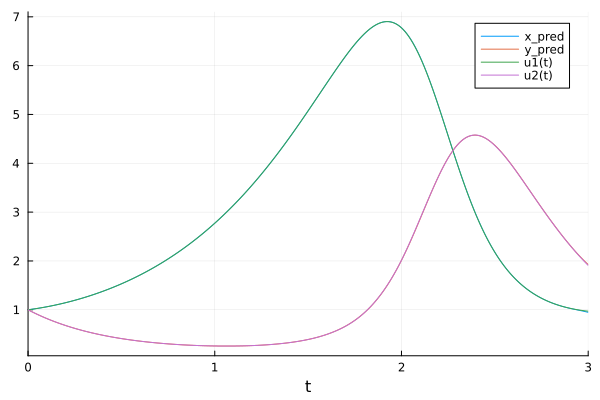

In [8]:
using Plots

phi = pinn.phi
ts = [true_sol.t...;;]
x_pred = phi.x(ts, res.u.x)
y_pred = phi.y(ts, res.u.y)

plot(vec(ts), vec(x_pred), label="x_pred")
plot!(vec(ts), vec(y_pred), label="y_pred")
plot!(true_sol)

In [14]:
maximum(sum(abs2, vcat(x_pred, y_pred) .- stack(true_sol.u); dims=1))

0.0008697122947862379

In [16]:
sampler = remake(sampler; α = 0.8)
data = Sophon.sample(lotka_volterra, sampler)
prob = remake(prob; p = data, u0 = res.u)

res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 0.0036305548916855794
Loss: 0.003438994979550389
Loss: 0.0033031353415787497
Loss: 0.0032454616791083657
Loss: 0.003063783958127952
Loss: 0.0026612131102734444
Loss: 0.002616410806804093
Loss: 0.002346067146779643
Loss: 0.0020835335934140057
Loss: 0.0018293665222978814
Loss: 0.0017408445910052114


Loss: 0.0016016024432065337
Loss: 0.0012688736470224734
Loss: 0.0010930366039123844
Loss: 0.0009840758374167944
Loss: 0.0008810466609586577
Loss: 0.0007235636873493295
Loss: 0.0006445199326254568
Loss: 0.0005596970007087596
Loss: 0.0005161571427281218
Loss: 0.0004767130190444172
Loss: 0.0004149469730365999
Loss: 0.00038828800513234196
Loss: 0.0003103602598585293
Loss: 0.00027179113894700685
Loss: 0.0002434704794964854
Loss: 0.00022004009710895848


Loss: 0.00019974586879916098
Loss: 0.0001829434613309694
Loss: 0.00017475003595665008
Loss: 0.0001686193539122128
Loss: 0.00016116867975695184
Loss: 0.000149329020771853
Loss: 0.00014259842644795645
Loss: 0.00013495863133680723
Loss: 0.00012683757704514382
Loss: 0.00012095673941741469
Loss: 0.00011809510954013147
Loss: 0.00011452078408533726
Loss: 0.00010960256788467509
Loss: 0.0001071826043025167
Loss: 0.00010572934896073993
Loss: 0.00010426979928060953


Loss: 0.00010209331245769115
Loss: 9.690848123699561e-5
Loss: 9.168831479864823e-5
Loss: 8.872846942476572e-5
Loss: 8.547871189629147e-5
Loss: 8.360870278247148e-5
Loss: 8.081677492625769e-5
Loss: 7.625176654395872e-5
Loss: 7.389602360012283e-5
Loss: 7.050999547466606e-5
Loss: 6.688789864785422e-5
Loss: 6.501327731870451e-5
Loss: 6.128081665727579e-5
Loss: 5.9576263381322116e-5
Loss: 5.8383732609457453e-5


Loss: 5.800847393651229e-5
Loss: 5.7331675626101415e-5
Loss: 5.637123524846136e-5
Loss: 5.499317782179427e-5
Loss: 5.391129558070773e-5
Loss: 5.313175676678138e-5
Loss: 5.274534235238406e-5
Loss: 5.1997674691875574e-5
Loss: 5.1293665864995566e-5
Loss: 5.049711273468313e-5
Loss: 4.96040243131118e-5
Loss: 4.832759161863951e-5
Loss: 4.7173418966448554e-5
Loss: 4.597866630409067e-5
Loss: 4.488018945756223e-5


Loss: 4.396910480465289e-5
Loss: 4.32482760989601e-5
Loss: 4.248701127857914e-5
Loss: 4.198145748599916e-5
Loss: 4.1714701498546176e-5
Loss: 4.1526129069253015e-5
Loss: 4.131135404408108e-5
Loss: 4.1152963015766864e-5
Loss: 4.102607417719327e-5
Loss: 4.078920162467695e-5
Loss: 3.9773525104819754e-5
Loss: 3.9047675100535635e-5
Loss: 3.8695111442179217e-5
Loss: 3.8505979674955266e-5


Loss: 3.8164323816751004e-5
Loss: 3.7556840807892214e-5
Loss: 3.647781142420055e-5
Loss: 3.566972069140446e-5
Loss: 3.529423577621066e-5
Loss: 3.4961470261321115e-5
Loss: 3.465868939596329e-5
Loss: 3.433852437985337e-5
Loss: 3.412421222823321e-5
Loss: 3.401112608013558e-5
Loss: 3.3955565139532166e-5
Loss: 3.3896964442572064e-5
Loss: 3.385460136547549e-5
Loss: 3.38083058112183e-5
Loss: 3.3766933663882666e-5
Loss: 3.370839903605017e-5


Loss: 3.363517405769382e-5
Loss: 3.359484726479104e-5
Loss: 3.355025386186097e-5
Loss: 3.351247706026759e-5
Loss: 3.346428297301168e-5
Loss: 3.3377462732483484e-5
Loss: 3.321542608329836e-5
Loss: 3.282358128295574e-5
Loss: 3.2346530682108803e-5
Loss: 3.162643640837097e-5
Loss: 3.113276484069124e-5
Loss: 3.0734868926720494e-5
Loss: 3.0517698546809446e-5
Loss: 3.0346274295661384e-5
Loss: 3.0243280316864957e-5
Loss: 2.9924289723767255e-5


Loss: 2.960841502903149e-5
Loss: 2.937890074925594e-5
Loss: 2.915333617892672e-5
Loss: 2.901570602456236e-5
Loss: 2.894864389197654e-5
Loss: 2.8881061247876884e-5
Loss: 2.8795385754014494e-5
Loss: 2.874047692055081e-5
Loss: 2.8698419145874047e-5
Loss: 2.8660842279159247e-5
Loss: 2.862906162360751e-5
Loss: 2.8576387141859913e-5
Loss: 2.8523298008897037e-5
Loss: 2.849454191055759e-5
Loss: 2.8436010735932512e-5
Loss: 2.836770889751981e-5
Loss: 2.83017309478739e-5


Loss: 2.828068220122744e-5
Loss: 2.8236670838505234e-5
Loss: 2.819224733134942e-5
Loss: 2.8132438231017302e-5
Loss: 2.8079833625115277e-5
Loss: 2.8000330752946905e-5
Loss: 2.791437222955223e-5
Loss: 2.7819587498742833e-5
Loss: 2.773850515225823e-5
Loss: 2.7627112669933833e-5
Loss: 2.7404893797028693e-5
Loss: 2.7205520753890203e-5
Loss: 2.697658586520699e-5
Loss: 2.66366627652072e-5


Loss: 2.644031879589709e-5
Loss: 2.629249447681505e-5
Loss: 2.616570353259386e-5
Loss: 2.607130915155894e-5
Loss: 2.5935536260588468e-5
Loss: 2.5829599048493637e-5
Loss: 2.563324302549638e-5
Loss: 2.5468283571003997e-5
Loss: 2.5263373725023078e-5
Loss: 2.5130071876881527e-5
Loss: 2.5053410844513994e-5
Loss: 2.4965250537971736e-5
Loss: 2.489866675225892e-5
Loss: 2.4768571794417937e-5
Loss: 2.4679945295532117e-5
Loss: 2.4608441275436312e-5


Loss: 2.449802889811729e-5
Loss: 2.433951007361942e-5
Loss: 2.4170762457760103e-5
Loss: 2.4031457183343366e-5
Loss: 2.3981972555844154e-5
Loss: 2.3914044726370697e-5
Loss: 2.3866562126021645e-5
Loss: 2.377679159852976e-5
Loss: 2.359763957871921e-5
Loss: 2.325666260007e-5
Loss: 2.278365564607434e-5
Loss: 2.2640766503856006e-5
Loss: 2.2240411270148644e-5
Loss: 2.2083798358941573e-5
Loss: 2.1918465911179953e-5


Loss: 2.1741166489525512e-5
Loss: 2.155611322655589e-5
Loss: 2.1422844448424834e-5
Loss: 2.131857206457468e-5
Loss: 2.1209641045481536e-5
Loss: 2.111955976061203e-5
Loss: 2.0970652363419473e-5
Loss: 2.0814128696542583e-5
Loss: 2.056520312352314e-5
Loss: 2.0064213677771382e-5
Loss: 1.9715602438177533e-5
Loss: 1.9097853504414663e-5
Loss: 1.8736300069139687e-5
Loss: 1.8447300866831464e-5
Loss: 1.8263312808829615e-5
Loss: 1.808301649874041e-5
Loss: 1.787684192454975e-5


Loss: 1.77860252830764e-5
Loss: 1.7620051517935006e-5
Loss: 1.7512440100120546e-5
Loss: 1.7309937860262975e-5
Loss: 1.7184027761968055e-5
Loss: 1.712170855128258e-5
Loss: 1.7065204601041764e-5
Loss: 1.7041941174606195e-5
Loss: 1.7023613759545868e-5
Loss: 1.699548249749578e-5
Loss: 1.6961775911151748e-5
Loss: 1.692320307630008e-5
Loss: 1.686950897211428e-5
Loss: 1.68158568003411e-5
Loss: 1.6718635801033327e-5
Loss: 1.6600536513218902e-5


Loss: 1.6424300260156132e-5
Loss: 1.6294948422765064e-5
Loss: 1.6178597276881474e-5
Loss: 1.6125203668499548e-5
Loss: 1.6075395358456396e-5
Loss: 1.604428388842508e-5
Loss: 1.6005290130492222e-5
Loss: 1.595645969396131e-5
Loss: 1.5874805338214072e-5
Loss: 1.5830209078258747e-5
Loss: 1.568217809599696e-5
Loss: 1.5589952500371385e-5
Loss: 1.539010146269067e-5
Loss: 1.5276578465898714e-5
Loss: 1.5135200873303405e-5
Loss: 1.5043398007780357e-5
Loss: 1.4881308101492575e-5
Loss: 1.4742077188649138e-5
Loss: 1.4480585163532757e-5


Loss: 1.4274029252511808e-5
Loss: 1.410548308083392e-5
Loss: 1.388876189119053e-5
Loss: 1.3699227271980644e-5
Loss: 1.3545355575490416e-5
Loss: 1.3334270123937644e-5
Loss: 1.3183018355366874e-5
Loss: 1.3113215090167636e-5
Loss: 1.2976489915184056e-5
Loss: 1.2883770673699465e-5
Loss: 1.2769980110402813e-5
Loss: 1.267467884265137e-5
Loss: 1.2542210821816277e-5
Loss: 1.2409835570052305e-5
Loss: 1.2257893141786752e-5
Loss: 1.2151642104519507e-5
Loss: 1.2047684546733814e-5
Loss: 1.1916263318321194e-5
Loss: 1.1795620717155809e-5
Loss: 1.1689847437369599e-5


Loss: 1.1564728660698948e-5
Loss: 1.1467947565700287e-5
Loss: 1.1420002172937615e-5
Loss: 1.138592608804008e-5
Loss: 1.1336167782629114e-5
Loss: 1.1273017216905738e-5
Loss: 1.1235111917039235e-5
Loss: 1.1199161981084723e-5
Loss: 1.1159781769362473e-5
Loss: 1.110185998537478e-5
Loss: 1.1061807726361315e-5
Loss: 1.1026895467529841e-5
Loss: 1.0939992594040608e-5
Loss: 1.0898232647628585e-5
Loss: 1.0794552186688656e-5


Loss: 1.0723335301920083e-5
Loss: 1.055869437374108e-5
Loss: 1.0425185849250902e-5
Loss: 1.0218287090948419e-5
Loss: 1.0126697664681429e-5
Loss: 9.847262133438856e-6
Loss: 9.506989219632037e-6
Loss: 9.328681894178942e-6
Loss: 9.114204873731445e-6
Loss: 9.01800480355343e-6
Loss: 8.956896182385433e-6
Loss: 8.893291825567617e-6
Loss: 8.838462584958315e-6
Loss: 8.758599625969174e-6
Loss: 8.693503933181941e-6


Loss: 8.615055591305007e-6
Loss: 8.52110447292836e-6
Loss: 8.408698756420497e-6
Loss: 8.297178997773462e-6
Loss: 8.184058837936505e-6
Loss: 8.118679124663195e-6
Loss: 8.076342304619632e-6
Loss: 8.050804675137096e-6
Loss: 8.038046843454136e-6
Loss: 8.027154370720547e-6
Loss: 8.020208378294296e-6
Loss: 7.997403049762334e-6
Loss: 7.94245640686719e-6
Loss: 7.865679613479725e-6
Loss: 7.751454173914193e-6


Loss: 7.639356039389783e-6
Loss: 7.514451979215211e-6
Loss: 7.425324421045269e-6
Loss: 7.326152154771675e-6
Loss: 7.168423003613357e-6
Loss: 7.061737212961764e-6
Loss: 6.872484971462705e-6
Loss: 6.756181132253785e-6
Loss: 6.658725614066113e-6
Loss: 6.55852257261595e-6
Loss: 6.506472303793892e-6
Loss: 6.471499477704061e-6
Loss: 6.457995530416101e-6
Loss: 6.44829832718453e-6
Loss: 6.440914928356953e-6
Loss: 6.425427735386532e-6


Loss: 6.411356016523694e-6
Loss: 6.389359474365925e-6
Loss: 6.359225471887184e-6
Loss: 6.340904667752983e-6
Loss: 6.332318154053159e-6
Loss: 6.316034223491689e-6
Loss: 6.298859045867831e-6
Loss: 6.278923546655771e-6
Loss: 6.261265250613221e-6
Loss: 6.227634029171803e-6
Loss: 6.1364206054694065e-6
Loss: 6.055800472154657e-6
Loss: 6.0086967831711435e-6
Loss: 5.954002590175221e-6


Loss: 5.923158882546203e-6
Loss: 5.907109011971655e-6
Loss: 5.899728492619417e-6
Loss: 5.8956269447677425e-6
Loss: 5.8926549301341684e-6
Loss: 5.890369782156197e-6
Loss: 5.889112889290428e-6
Loss: 5.887446018326755e-6
Loss: 5.885146023155662e-6
Loss: 5.883181734365175e-6
Loss: 5.881267891253171e-6
Loss: 5.877444398958843e-6
Loss: 5.86414375573023e-6
Loss: 5.7752018193660005e-6
Loss: 5.6772330197137244e-6


Loss: 5.583265958220232e-6
Loss: 5.477876964236052e-6
Loss: 5.4044283014510615e-6
Loss: 5.327612520299175e-6
Loss: 5.29611967365627e-6
Loss: 5.208555361463292e-6
Loss: 5.102811237677079e-6
Loss: 5.006947006633168e-6
Loss: 4.955730844994326e-6
Loss: 4.924547557302415e-6
Loss: 4.8678193219945246e-6
Loss: 4.8216193574008934e-6
Loss: 4.792342029176022e-6
Loss: 4.761398210213197e-6
Loss: 4.742660204524676e-6
Loss: 4.706230829526367e-6
Loss: 4.693928527222974e-6
Loss: 4.657106426218576e-6


Loss: 4.646131020603241e-6
Loss: 4.625535815614487e-6
Loss: 4.606757223048844e-6
Loss: 4.584451611761676e-6
Loss: 4.554671825975123e-6
Loss: 4.515895659134999e-6
Loss: 4.4933911986569745e-6
Loss: 4.475113496000501e-6
Loss: 4.45894727062981e-6
Loss: 4.4279151687375094e-6
Loss: 4.381771860926655e-6
Loss: 4.337761769951234e-6
Loss: 4.306797154342781e-6
Loss: 4.262137788938045e-6
Loss: 4.196212466883421e-6


Loss: 4.161967844355131e-6
Loss: 4.12745300967567e-6
Loss: 4.096656855117442e-6
Loss: 4.065515477289975e-6
Loss: 4.0449615543496725e-6
Loss: 4.01193258499677e-6
Loss: 3.981093556324829e-6
Loss: 3.939566225614488e-6
Loss: 3.917375927342328e-6
Loss: 3.893300578480764e-6
Loss: 3.867204582853004e-6
Loss: 3.8288234641257455e-6


Loss: 3.7878959482940143e-6
Loss: 3.7460280113337664e-6
Loss: 3.69767522779117e-6
Loss: 3.6348003960594173e-6
Loss: 3.5920340141629107e-6
Loss: 3.5086732490722598e-6
Loss: 3.452256267230461e-6
Loss: 3.3099387614663473e-6
Loss: 3.187814930149522e-6
Loss: 3.132754118426917e-6
Loss: 3.0503163656289154e-6
Loss: 2.991835795642935e-6
Loss: 2.94805674359627e-6
Loss: 2.901669217070615e-6


Loss: 2.8602476442036286e-6
Loss: 2.830201977480317e-6
Loss: 2.8141749805937946e-6
Loss: 2.791599540923389e-6
Loss: 2.768288504090015e-6
Loss: 2.7481203110253298e-6
Loss: 2.7216567872267437e-6
Loss: 2.6932464057346617e-6
Loss: 2.6716125669528096e-6
Loss: 2.6569829288809228e-6
Loss: 2.646660342629797e-6
Loss: 2.6423829272675437e-6
Loss: 2.6402338067077246e-6
Loss: 2.639432918583522e-6
Loss: 2.6387501758985468e-6


Loss: 2.6379137444565707e-6
Loss: 2.6369215810861817e-6
Loss: 2.6339667658546454e-6
Loss: 2.6254748231935694e-6
Loss: 2.61608842835642e-6
Loss: 2.605535520204391e-6
Loss: 2.5925729290583236e-6
Loss: 2.5732273329410975e-6
Loss: 2.5509961782586764e-6
Loss: 2.5330222077409877e-6
Loss: 2.5161849061886154e-6
Loss: 2.4967890353593598e-6
Loss: 2.4767949828890483e-6


Loss: 2.4654254127934602e-6
Loss: 2.4582615301134806e-6
Loss: 2.451426962128369e-6
Loss: 2.4493718758413315e-6
Loss: 2.4477347726932133e-6
Loss: 2.44548595621788e-6
Loss: 2.4387516498413855e-6
Loss: 2.425946437488399e-6
Loss: 2.4168884792257943e-6
Loss: 2.412693118857424e-6
Loss: 2.4094086976695743e-6
Loss: 2.407430589730962e-6
Loss: 2.4046143845845636e-6
Loss: 2.396311954370966e-6


Loss: 2.3811291468182626e-6
Loss: 2.346774321135588e-6
Loss: 2.3220932151695335e-6
Loss: 2.287738054553278e-6
Loss: 2.256476060229167e-6
Loss: 2.188176870138562e-6
Loss: 2.1558096984957497e-6
Loss: 2.137089884937568e-6
Loss: 2.1226188998832668e-6
Loss: 2.1017061654212934e-6
Loss: 2.0945310852063127e-6
Loss: 2.0738484890981656e-6
Loss: 2.065664790198808e-6
Loss: 2.053025986029176e-6
Loss: 2.041632231742021e-6
Loss: 2.034132789152636e-6
Loss: 2.0277953991518716e-6


Loss: 2.0233440677723742e-6
Loss: 2.0212105932887485e-6
Loss: 2.019721100936339e-6
Loss: 2.0179786594496053e-6
Loss: 2.015336537148223e-6
Loss: 2.0099900831766825e-6
Loss: 2.002875726417034e-6
Loss: 1.9987128439318503e-6
Loss: 1.99178328211096e-6
Loss: 1.984219320224536e-6
Loss: 1.975802428442212e-6
Loss: 1.967844714020772e-6
Loss: 1.960946434512683e-6


Loss: 1.9447618242089406e-6
Loss: 1.9296655098337265e-6
Loss: 1.9213871034948225e-6
Loss: 1.9147665317867616e-6
Loss: 1.907701519896848e-6
Loss: 1.901451427688066e-6
Loss: 1.8972645645411516e-6
Loss: 1.8910368737133167e-6
Loss: 1.8840960537614505e-6
Loss: 1.8765094286956189e-6
Loss: 1.8629417479514193e-6
Loss: 1.8496349375960218e-6
Loss: 1.8369072897764692e-6
Loss: 1.8272793935608827e-6
Loss: 1.8114810522197924e-6


Loss: 1.8023094083006572e-6
Loss: 1.789959454988199e-6
Loss: 1.7827394954604788e-6
Loss: 1.7768842701263286e-6
Loss: 1.7735327191218182e-6
Loss: 1.769506506719076e-6
Loss: 1.7643436627560972e-6
Loss: 1.75894695508312e-6
Loss: 1.7538902661868801e-6
Loss: 1.7512504354858299e-6
Loss: 1.749862284777703e-6
Loss: 1.7488285345475497e-6
Loss: 1.7476556728745888e-6
Loss: 1.7461905916625373e-6


Loss: 1.7450978445686457e-6
Loss: 1.7435816617208773e-6
Loss: 1.7426579732516562e-6
Loss: 1.7420015868400069e-6
Loss: 1.7410097098819342e-6
Loss: 1.738251314352727e-6
Loss: 1.7338996852079915e-6
Loss: 1.727146592253141e-6
Loss: 1.7220064228852777e-6
Loss: 1.7168500418546477e-6
Loss: 1.7115012550965351e-6
Loss: 1.7039310375235353e-6


Loss: 1.687274186462726e-6
Loss: 1.6707865883488143e-6
Loss: 1.649088301411095e-6
Loss: 1.632151519650709e-6
Loss: 1.619463112700103e-6
Loss: 1.6045218359868348e-6
Loss: 1.5925279091309997e-6
Loss: 1.5873062578716123e-6
Loss: 1.5768280140698028e-6
Loss: 1.5706454348404522e-6
Loss: 1.5665703463769567e-6
Loss: 1.5630278571228431e-6
Loss: 1.5608730049353152e-6
Loss: 1.559006025795736e-6
Loss: 1.557492643936773e-6
Loss: 1.5563807652530187e-6


Loss: 1.554690567905287e-6
Loss: 1.5514019767497115e-6
Loss: 1.5455884201853897e-6
Loss: 1.5358165005669667e-6
Loss: 1.528215618609641e-6
Loss: 1.5216217167317433e-6
Loss: 1.514293421760754e-6
Loss: 1.5061934284325214e-6
Loss: 1.4938563095967695e-6
Loss: 1.4851762654454078e-6
Loss: 1.477653713187008e-6
Loss: 1.463126465682222e-6


Loss: 1.4586489409226577e-6
Loss: 1.4440533654408512e-6
Loss: 1.4393900398842943e-6
Loss: 1.4287071934902916e-6
Loss: 1.4232543222515649e-6
Loss: 1.4080021371702093e-6
Loss: 1.39651567919627e-6
Loss: 1.3911327698935648e-6
Loss: 1.3809620208009117e-6
Loss: 1.3729199909862298e-6
Loss: 1.370191345893911e-6
Loss: 1.364308620458599e-6
Loss: 1.3550827993256915e-6
Loss: 1.3514075228442558e-6
Loss: 1.3473249904048345e-6
Loss: 1.3429585597379853e-6


Loss: 1.3396149706385148e-6
Loss: 1.333994339844053e-6
Loss: 1.32978844955169e-6
Loss: 1.3269194804277126e-6
Loss: 1.3250551825425113e-6
Loss: 1.32246488299943e-6
Loss: 1.3209103717332772e-6
Loss: 1.318950922163323e-6
Loss: 1.3178595752716504e-6
Loss: 1.3169971479900462e-6
Loss: 1.3161943580335985e-6
Loss: 1.3156205381646042e-6
Loss: 1.314886024244395e-6
Loss: 1.3142274356655802e-6
Loss: 1.3128743052313177e-6


Loss: 1.3110985452813644e-6
Loss: 1.3090745269212678e-6
Loss: 1.3078459444370876e-6
Loss: 1.306819258000259e-6
Loss: 1.3050275601382796e-6
Loss: 1.3024390189478668e-6
Loss: 1.3003923912858676e-6
Loss: 1.2973158629145322e-6
Loss: 1.29283233198271e-6
Loss: 1.2867782142799176e-6
Loss: 1.282079462920325e-6
Loss: 1.27545705000731e-6
Loss: 1.2687958020643595e-6
Loss: 1.2589828709624798e-6


Loss: 1.2528155474316851e-6
Loss: 1.2478738008643844e-6
Loss: 1.2455522021428655e-6
Loss: 1.2427487525081927e-6
Loss: 1.2410684281376512e-6
Loss: 1.2399679139536299e-6
Loss: 1.2391926116882877e-6
Loss: 1.2382774795871984e-6
Loss: 1.2361274185238086e-6
Loss: 1.2319512117959685e-6
Loss: 1.227599266554185e-6
Loss: 1.2238129130837978e-6
Loss: 1.215912766391654e-6
Loss: 1.2047675997555339e-6


Loss: 1.2011396135529e-6
Loss: 1.1961875176038695e-6
Loss: 1.188981255160881e-6
Loss: 1.1790723083639897e-6
Loss: 1.1750863440775967e-6
Loss: 1.1694175226331038e-6
Loss: 1.1652010013455393e-6
Loss: 1.160546681141437e-6
Loss: 1.1537202102344385e-6
Loss: 1.1459965093743863e-6
Loss: 1.1357414572311736e-6
Loss: 1.132250870237763e-6
Loss: 1.1230004933254532e-6
Loss: 1.1208385340481493e-6
Loss: 1.115622749665036e-6


Loss: 1.1121108648249454e-6
Loss: 1.1078212952944313e-6
Loss: 1.1052228932596401e-6
Loss: 1.1023179159923657e-6
Loss: 1.1015093818534022e-6
Loss: 1.1003016423730563e-6
Loss: 1.0989519151226664e-6
Loss: 1.0968765433555723e-6
Loss: 1.093401717040717e-6
Loss: 1.0889617350544814e-6
Loss: 1.0834020758349505e-6
Loss: 1.0762818696202678e-6
Loss: 1.0667708367013674e-6
Loss: 1.0502375667770558e-6
Loss: 1.0295266137528752e-6


Loss: 1.0067682312226234e-6
Loss: 9.96444108180381e-7
Loss: 9.604550832370116e-7
Loss: 9.231286846487819e-7
Loss: 9.024788385863721e-7
Loss: 8.819315799365539e-7
Loss: 8.697118392103521e-7
Loss: 8.52592090422401e-7
Loss: 8.433752405503438e-7
Loss: 8.360825009379462e-7
Loss: 8.317304477640972e-7
Loss: 8.269162017717544e-7
Loss: 8.230403299807192e-7
Loss: 8.203099639633355e-7
Loss: 8.185790464901513e-7
Loss: 8.142698111360521e-7
Loss: 8.10441952673299e-7


Loss: 8.064990836667072e-7
Loss: 8.018533440249988e-7
Loss: 7.967536807964779e-7
Loss: 7.932121976965876e-7
Loss: 7.893759786745336e-7
Loss: 7.850268677520339e-7
Loss: 7.812120831811397e-7
Loss: 7.775057689710429e-7
Loss: 7.740558761465003e-7
Loss: 7.702973404439689e-7
Loss: 7.683282988851554e-7
Loss: 7.639075242528337e-7
Loss: 7.612698384713573e-7
Loss: 7.585856308236899e-7
Loss: 7.568241796764506e-7
Loss: 7.550292747439641e-7


Loss: 7.519455578793842e-7
Loss: 7.493472617259598e-7
Loss: 7.465982236965359e-7
Loss: 7.438579348007719e-7
Loss: 7.416248938863648e-7
Loss: 7.404558802685084e-7
Loss: 7.39152966771159e-7
Loss: 7.382274527213048e-7
Loss: 7.377463640124614e-7
Loss: 7.374763437344689e-7
Loss: 7.367172395560519e-7
Loss: 7.355825086968147e-7
Loss: 7.34942183983423e-7
Loss: 7.346268085770749e-7
Loss: 7.342490538097738e-7


Loss: 7.33220501779583e-7
Loss: 7.305578322735984e-7
Loss: 7.256544909782229e-7
Loss: 7.220375511701014e-7
Loss: 7.206370489140503e-7
Loss: 7.189946817224168e-7
Loss: 7.176934693601442e-7
Loss: 7.147705236995288e-7
Loss: 7.126976483595133e-7
Loss: 7.117166316797412e-7
Loss: 7.095329797950073e-7
Loss: 7.038635356142527e-7
Loss: 6.963357209728312e-7
Loss: 6.872177724684046e-7
Loss: 6.819058465653359e-7


Loss: 6.658418357590426e-7
Loss: 6.58717964690611e-7
Loss: 6.523597741373259e-7
Loss: 6.46796092283778e-7
Loss: 6.41605146709629e-7
Loss: 6.369182187054284e-7
Loss: 6.246588532971678e-7
Loss: 6.176764668707095e-7
Loss: 6.081187992935738e-7
Loss: 6.05687089697195e-7
Loss: 5.954433769816988e-7
Loss: 5.87746380259373e-7
Loss: 5.835473775027455e-7
Loss: 5.791631668962549e-7
Loss: 5.76361340984372e-7
Loss: 5.709952176097657e-7
Loss: 5.68238237850659e-7
Loss: 5.648894391238447e-7
Loss: 5.600719248939254e-7


Loss: 5.546195841879083e-7
Loss: 5.516763703684573e-7
Loss: 5.469678296340646e-7
Loss: 5.452290339836623e-7
Loss: 5.429239319674934e-7
Loss: 5.41995606630877e-7
Loss: 5.412090635515743e-7
Loss: 5.402666229853648e-7
Loss: 5.390009453144887e-7
Loss: 5.379578624636438e-7
Loss: 5.371804615631545e-7
Loss: 5.365757375857544e-7
Loss: 5.359134307061941e-7
Loss: 5.353671451879936e-7
Loss: 5.349476278937592e-7
Loss: 5.345453614176875e-7


Loss: 5.342170080802531e-7
Loss: 5.340323292718211e-7
Loss: 5.338764214638403e-7
Loss: 5.336877211468241e-7
Loss: 5.333621151079904e-7
Loss: 5.33231129747789e-7
Loss: 5.32915572227482e-7
Loss: 5.327219460761558e-7
Loss: 5.325461325389021e-7
Loss: 5.324065593807701e-7
Loss: 5.32037062369547e-7
Loss: 5.303819691815048e-7
Loss: 5.280151714014403e-7


Loss: 5.256817389012911e-7
Loss: 5.241268969822589e-7
Loss: 5.222933816134188e-7
Loss: 5.205419230337609e-7
Loss: 5.18552927504385e-7
Loss: 5.164393499521708e-7
Loss: 5.14651674116424e-7
Loss: 5.100977895072424e-7
Loss: 5.088138022846791e-7
Loss: 5.039943233808181e-7
Loss: 5.02078665131868e-7
Loss: 4.948666259331397e-7
Loss: 4.923846668166081e-7
Loss: 4.89378861302503e-7
Loss: 4.883924911370373e-7
Loss: 4.875444704579598e-7
Loss: 4.866930171870644e-7


Loss: 4.857416151749954e-7
Loss: 4.847249310367845e-7
Loss: 4.823636316127167e-7
Loss: 4.783361259394228e-7
Loss: 4.769755836040091e-7
Loss: 4.744906377160037e-7
Loss: 4.7346245155547653e-7
Loss: 4.716623528371798e-7
Loss: 4.700580395751655e-7
Loss: 4.684345393877529e-7
Loss: 4.661495620326505e-7
Loss: 4.635634730822573e-7
Loss: 4.6273125241947433e-7
Loss: 4.614957599080572e-7
Loss: 4.6028963061719043e-7


Loss: 4.5832946054829544e-7
Loss: 4.5577074373939635e-7
Loss: 4.5442807888517097e-7
Loss: 4.527711518830168e-7
Loss: 4.506425161094311e-7
Loss: 4.4962294401746265e-7
Loss: 4.4852756898112824e-7
Loss: 4.460238462459262e-7
Loss: 4.439503583309436e-7
Loss: 4.404227529549946e-7
Loss: 4.3804184689110433e-7
Loss: 4.356120048916898e-7
Loss: 4.3334654241094757e-7
Loss: 4.31819493503866e-7
Loss: 4.2973861598564066e-7
Loss: 4.287114979752769e-7


Loss: 4.2688029239079117e-7
Loss: 4.254184248283919e-7
Loss: 4.225533396570406e-7
Loss: 4.208991141492073e-7
Loss: 4.1935992587156584e-7
Loss: 4.1838988371491865e-7
Loss: 4.1661625038206653e-7
Loss: 4.147412950995892e-7
Loss: 4.124629561541238e-7
Loss: 4.085068340292121e-7
Loss: 4.033448725117061e-7
Loss: 4.0259082186552444e-7
Loss: 3.992950772507985e-7


Loss: 3.9829709621290953e-7
Loss: 3.9679307884584905e-7
Loss: 3.9632418702149853e-7
Loss: 3.9504648190850994e-7
Loss: 3.9420403411269344e-7
Loss: 3.9300407868805826e-7
Loss: 3.9144959396853853e-7
Loss: 3.900870397191723e-7
Loss: 3.890105066530504e-7
Loss: 3.877976560162619e-7
Loss: 3.8697454629914176e-7
Loss: 3.8624627886434885e-7
Loss: 3.8600144199563003e-7
Loss: 3.858471533565901e-7


Loss: 3.8576537840124825e-7
Loss: 3.855766197366423e-7
Loss: 3.8516476544596525e-7
Loss: 3.848146158336236e-7
Loss: 3.844611034775268e-7
Loss: 3.837745004200656e-7
Loss: 3.8294918190341513e-7
Loss: 3.8224498808646994e-7
Loss: 3.81466798545336e-7
Loss: 3.8102112852907014e-7
Loss: 3.807106275859678e-7
Loss: 3.8047764520944786e-7


Loss: 3.7976613797499827e-7
Loss: 3.786900108062005e-7
Loss: 3.776258146184284e-7
Loss: 3.773033108059687e-7
Loss: 3.771065262561095e-7
Loss: 3.7693131661451783e-7
Loss: 3.764667911617561e-7
Loss: 3.762312192013442e-7
Loss: 3.760509746803662e-7
Loss: 3.7562717785655377e-7
Loss: 3.7419970084592934e-7
Loss: 3.7159798384701474e-7
Loss: 3.693870261246835e-7


Loss: 3.6615848119466843e-7
Loss: 3.6243199945722446e-7
Loss: 3.6032507309936445e-7
Loss: 3.5820261192659037e-7
Loss: 3.570387695609954e-7
Loss: 3.5315016158913387e-7
Loss: 3.4781127520123995e-7
Loss: 3.38346893731159e-7
Loss: 3.3263224858818554e-7
Loss: 3.247129386526513e-7
Loss: 3.2044707915823066e-7
Loss: 3.1518877712967007e-7
Loss: 3.1022127180527866e-7
Loss: 3.060707235975237e-7
Loss: 3.0100476733108315e-7
Loss: 2.994206655762209e-7


Loss: 2.980422436826839e-7
Loss: 2.971926667302914e-7
Loss: 2.9625593367736415e-7
Loss: 2.9493612466938355e-7
Loss: 2.9376549380855475e-7
Loss: 2.9186380471257753e-7
Loss: 2.9102147329789356e-7
Loss: 2.890791140650644e-7
Loss: 2.872246870523164e-7
Loss: 2.8641840678236525e-7
Loss: 2.858881029738932e-7
Loss: 2.853126631011819e-7
Loss: 2.8476966138807303e-7
Loss: 2.842543444554921e-7


Loss: 2.8377715846947037e-7
Loss: 2.8332719970865343e-7
Loss: 2.829507131228072e-7
Loss: 2.8242030881718193e-7
Loss: 2.8126444171356923e-7
Loss: 2.791424713322989e-7
Loss: 2.765721568705059e-7
Loss: 2.7540732430243e-7
Loss: 2.7524194639893376e-7
Loss: 2.7447209636427814e-7
Loss: 2.7380645437754285e-7
Loss: 2.728209801225949e-7


Loss: 2.720083774932626e-7
Loss: 2.7153032974417083e-7
Loss: 2.709523911260446e-7
Loss: 2.7056719346314735e-7
Loss: 2.7016749688249246e-7
Loss: 2.6934126131677536e-7
Loss: 2.686555720583221e-7
Loss: 2.682446678179928e-7
Loss: 2.680153944946608e-7
Loss: 2.678851822069848e-7
Loss: 2.67772626615837e-7
Loss: 2.676322639754027e-7


Loss: 2.674625206114918e-7
Loss: 2.672410793159979e-7
Loss: 2.669205418073723e-7
Loss: 2.6655373237931464e-7
Loss: 2.663680473711825e-7
Loss: 2.662217138820662e-7
Loss: 2.6618163302456423e-7
Loss: 2.6616934069830216e-7


Loss: 2.661641330481599e-7
Loss: 2.6615751937940924e-7
Loss: 2.661465158038685e-7
Loss: 2.661288198183908e-7
Loss: 2.660903457642299e-7
Loss: 2.6601766098895197e-7
Loss: 2.658973583401745e-7
Loss: 2.6560057136902076e-7
Loss: 2.651977346551742e-7
Loss: 2.649366063161879e-7
Loss: 2.6468524860232676e-7


Loss: 2.64346473585877e-7
Loss: 2.6423678930206994e-7
Loss: 2.6412304118689955e-7
Loss: 2.640635239449414e-7
Loss: 2.640386628010783e-7
Loss: 2.6402817280529773e-7
Loss: 2.6400957241274584e-7
Loss: 2.6396734771600374e-7
Loss: 2.6392348101845714e-7
Loss: 2.6390515099108373e-7
Loss: 2.6385518454832676e-7
Loss: 2.637199366926536e-7


Loss: 2.6351794981328376e-7
Loss: 2.6302499890641176e-7
Loss: 2.6230373289604444e-7
Loss: 2.603560705064369e-7
Loss: 2.580054210550484e-7
Loss: 2.5525584602258284e-7
Loss: 2.5196540543297366e-7
Loss: 2.4963603207309054e-7
Loss: 2.489105730149773e-7
Loss: 2.4674116631786483e-7
Loss: 2.4599424522137644e-7
Loss: 2.4462854684727473e-7
Loss: 2.4395988421324957e-7
Loss: 2.4350166385958034e-7


Loss: 2.4301887374432745e-7
Loss: 2.423816055725577e-7
Loss: 2.421357899237294e-7
Loss: 2.416299237317338e-7
Loss: 2.4127949356016704e-7
Loss: 2.4104877308896144e-7
Loss: 2.408753723112902e-7
Loss: 2.4077532776202843e-7
Loss: 2.4068915194704907e-7
Loss: 2.405674976479156e-7
Loss: 2.4042144367068797e-7
Loss: 2.402460197261677e-7


Loss: 2.400774819915428e-7
Loss: 2.399391685989847e-7
Loss: 2.3981136099837575e-7
Loss: 2.3969459227043775e-7
Loss: 2.3962893937135793e-7
Loss: 2.395786821930636e-7
Loss: 2.395492126836853e-7
Loss: 2.3953536387595044e-7
Loss: 2.3952212723582906e-7
Loss: 2.39504591697885e-7
Loss: 2.394833371043471e-7
Loss: 2.394577692027651e-7


Loss: 2.3942951111754286e-7
Loss: 2.3938178847709363e-7
Loss: 2.3927620736676316e-7
Loss: 2.3904257370309523e-7
Loss: 2.3751994810355756e-7
Loss: 2.365007996295471e-7
Loss: 2.3568365627853347e-7
Loss: 2.3513099405487463e-7
Loss: 2.345850884431387e-7
Loss: 2.34126932831175e-7
Loss: 2.3332054723357034e-7
Loss: 2.3266211121663437e-7
Loss: 2.319396312369424e-7


Loss: 2.308128485635629e-7
Loss: 2.3040436167021613e-7
Loss: 2.286981818510306e-7
Loss: 2.279667935209149e-7
Loss: 2.2682323103118115e-7
Loss: 2.259686218044101e-7
Loss: 2.2555058652444321e-7
Loss: 2.244052279050263e-7
Loss: 2.241102827423901e-7
Loss: 2.2313853543457097e-7
Loss: 2.220926850249574e-7
Loss: 2.2074792393848492e-7
Loss: 2.1989518701556898e-7
Loss: 2.1838695873744024e-7
Loss: 2.177027023810714e-7


Loss: 2.1602126653607316e-7
Loss: 2.153324840063359e-7
Loss: 2.141608812385073e-7
Loss: 2.122210652554596e-7
Loss: 2.1060608134315915e-7
Loss: 2.098344725903628e-7
Loss: 2.0810820117372843e-7
Loss: 2.0741593163340655e-7
Loss: 2.059996059931249e-7
Loss: 2.0505760491038858e-7
Loss: 2.0402698572960822e-7
Loss: 2.0313319633013903e-7
Loss: 2.0234328363788013e-7
Loss: 2.0171203641102385e-7
Loss: 2.0080086664238602e-7


Loss: 1.982304001809234e-7
Loss: 1.9453698644309132e-7
Loss: 1.9395196481788653e-7
Loss: 1.9189004754498382e-7
Loss: 1.9030618282140444e-7
Loss: 1.8914314682011142e-7
Loss: 1.8843251197322455e-7
Loss: 1.8792428605501443e-7
Loss: 1.8730101379067975e-7
Loss: 1.8624741545042137e-7
Loss: 1.8500344750020468e-7
Loss: 1.837516343145305e-7
Loss: 1.8280960666390483e-7
Loss: 1.8164882537535997e-7
Loss: 1.8013006457016335e-7


Loss: 1.7892396275525988e-7
Loss: 1.778437399364246e-7
Loss: 1.766041444422714e-7
Loss: 1.7598735510720567e-7
Loss: 1.752792751096394e-7
Loss: 1.744980662849424e-7
Loss: 1.7398083914377463e-7
Loss: 1.7340835974461705e-7
Loss: 1.7287871760924364e-7
Loss: 1.7261723401734177e-7
Loss: 1.7207608265580985e-7
Loss: 1.7137397880294868e-7
Loss: 1.704443738188632e-7
Loss: 1.6938906739533623e-7
Loss: 1.6803336177830447e-7
Loss: 1.6696349671852234e-7
Loss: 1.6598400789787667e-7


Loss: 1.652628824001137e-7
Loss: 1.6477446584672652e-7
Loss: 1.6450170290724416e-7
Loss: 1.6416288522175147e-7
Loss: 1.6377317485888957e-7
Loss: 1.6334289694860038e-7
Loss: 1.6288907208294088e-7
Loss: 1.6236519732943656e-7
Loss: 1.618790243405542e-7
Loss: 1.6160753292620842e-7
Loss: 1.6125315213129976e-7
Loss: 1.6084421532441716e-7
Loss: 1.604550440431783e-7
Loss: 1.601745296062388e-7


Loss: 1.5989234439480144e-7
Loss: 1.5974229545960658e-7
Loss: 1.5952562802101578e-7
Loss: 1.5923859309545468e-7
Loss: 1.5905182805048266e-7
Loss: 1.589558293000749e-7
Loss: 1.5890065066328493e-7
Loss: 1.5886738790363525e-7
Loss: 1.5882200839292068e-7
Loss: 1.5876865829383357e-7
Loss: 1.5870673960210215e-7
Loss: 1.5851855340953314e-7
Loss: 1.5805354503983883e-7
Loss: 1.5777231328818212e-7
Loss: 1.5709981222774607e-7
Loss: 1.564381582951095e-7


Loss: 1.5605175257159925e-7
Loss: 1.5582656564932934e-7
Loss: 1.5567050461059137e-7
Loss: 1.555795198504151e-7
Loss: 1.5550559276306024e-7
Loss: 1.5542785350674765e-7
Loss: 1.5536932055826945e-7
Loss: 1.5531308238499955e-7
Loss: 1.5520703948370164e-7
Loss: 1.55080543007042e-7
Loss: 1.5500557421460244e-7
Loss: 1.5493686090157398e-7
Loss: 1.548496367779997e-7


Loss: 1.5482892123960457e-7
Loss: 1.5482284271605083e-7
Loss: 1.548163904375286e-7
Loss: 1.5480867307166576e-7
Loss: 1.5480149823702154e-7
Loss: 1.5477427653814613e-7
Loss: 1.5467724287504605e-7
Loss: 1.5458881473523486e-7
Loss: 1.5448969881485813e-7
Loss: 1.5437748951954982e-7
Loss: 1.5433348934204798e-7
Loss: 1.543055216952499e-7
Loss: 1.5429734725483297e-7
Loss: 1.5429265058261305e-7


Loss: 1.5428293095261234e-7
Loss: 1.542401681160811e-7
Loss: 1.540369960330243e-7
Loss: 1.5380365954096995e-7
Loss: 1.5370130821759338e-7
Loss: 1.536773764801061e-7
Loss: 1.536692030387143e-7
Loss: 1.536670767304428e-7
Loss: 1.5366617557153833e-7
Loss: 1.5366472492233873e-7
Loss: 1.5365175510494602e-7
Loss: 1.5354682379477566e-7
Loss: 1.5337756748685622e-7


Loss: 1.5320462206159712e-7
Loss: 1.5312326240895575e-7
Loss: 1.528803869393707e-7
Loss: 1.524959859810154e-7
Loss: 1.5198250591984824e-7
Loss: 1.5182595340199973e-7
Loss: 1.5140545602688013e-7
Loss: 1.5117378673652404e-7
Loss: 1.5028600413301272e-7
Loss: 1.4985024847781466e-7
Loss: 1.486196401387216e-7
Loss: 1.4737291699533888e-7
Loss: 1.4709518035197776e-7
Loss: 1.4636932731442273e-7
Loss: 1.4569162893413563e-7
Loss: 1.4520791774491153e-7


Loss: 1.4467130192566566e-7
Loss: 1.4435004680749986e-7
Loss: 1.4397318496876087e-7
Loss: 1.4323589365201617e-7
Loss: 1.4282391995732845e-7
Loss: 1.4229077965522195e-7
Loss: 1.4199913392827077e-7
Loss: 1.416719699364719e-7
Loss: 1.412934129417441e-7
Loss: 1.4077426165966585e-7
Loss: 1.405980650716748e-7
Loss: 1.402089716602654e-7
Loss: 1.4002517305728733e-7
Loss: 1.3971403226170013e-7
Loss: 1.395028080372122e-7
Loss: 1.393060137273756e-7
Loss: 1.3907193058528066e-7
Loss: 1.38976487235367e-7
Loss: 1.388776227233567e-7


Loss: 1.3883129087876042e-7
Loss: 1.3876901840251564e-7
Loss: 1.3873532475072704e-7
Loss: 1.3869529063131171e-7
Loss: 1.3865514369376759e-7
Loss: 1.3861176717393432e-7
Loss: 1.385585182069787e-7
Loss: 1.3847552425539364e-7
Loss: 1.384085014071093e-7
Loss: 1.3833195535004464e-7
Loss: 1.3824919767990203e-7
Loss: 1.381927218454236e-7
Loss: 1.3816235749208185e-7


Loss: 1.3812777568805504e-7
Loss: 1.3810174598633048e-7
Loss: 1.3807214424495892e-7
Loss: 1.3805241914677547e-7
Loss: 1.3804184159693376e-7
Loss: 1.380325214493645e-7
Loss: 1.3801878279112847e-7
Loss: 1.3799996888199575e-7
Loss: 1.3798769002214003e-7
Loss: 1.3797721192362375e-7
Loss: 1.3795930256517954e-7
Loss: 1.3793224445712042e-7
Loss: 1.378667029322067e-7


Loss: 1.3771534510313838e-7
Loss: 1.3763296223180348e-7
Loss: 1.375993612362001e-7
Loss: 1.3758124036139853e-7
Loss: 1.3757329817118322e-7
Loss: 1.375667745825982e-7
Loss: 1.3756149289132696e-7
Loss: 1.3755528255516282e-7
Loss: 1.3754202012377043e-7
Loss: 1.3752167272854308e-7
Loss: 1.375114866102074e-7
Loss: 1.3750278572798228e-7
Loss: 1.3750001071527612e-7
Loss: 1.3749836968002433e-7


Loss: 1.3749727779343432e-7
Loss: 1.3749562704000288e-7
Loss: 1.3748974591032452e-7
Loss: 1.3746631969739713e-7
Loss: 1.373836242504134e-7
Loss: 1.3726596038591477e-7
Loss: 1.3717754095942828e-7
Loss: 1.3711359126776495e-7
Loss: 1.3704370668614294e-7
Loss: 1.370125919473655e-7
Loss: 1.3699562976160808e-7
Loss: 1.369837564022139e-7
Loss: 1.36968330237228e-7
Loss: 1.3693437001188942e-7
Loss: 1.3684222051030795e-7


Loss: 1.3660894183277254e-7
Loss: 1.3650648105409535e-7
Loss: 1.3607523788970942e-7
Loss: 1.3588212727345697e-7
Loss: 1.3532198320965414e-7
Loss: 1.350735286128668e-7
Loss: 1.3473144809492815e-7
Loss: 1.339997897340396e-7
Loss: 1.3362459622436428e-7
Loss: 1.3322033109544048e-7
Loss: 1.328655887891525e-7
Loss: 1.319442701779155e-7
Loss: 1.311772330332138e-7
Loss: 1.302588835185887e-7
Loss: 1.2997530774048544e-7


Loss: 1.292442379028556e-7
Loss: 1.2886170390722791e-7
Loss: 1.281566399831186e-7
Loss: 1.2750974315562357e-7
Loss: 1.271309415947515e-7
Loss: 1.2697073968416406e-7
Loss: 1.2683497931615863e-7
Loss: 1.2672219859301003e-7
Loss: 1.2663718461555412e-7
Loss: 1.265612061751328e-7
Loss: 1.2646339642174672e-7
Loss: 1.2637819619242182e-7
Loss: 1.2626882828469316e-7
Loss: 1.261787214757135e-7
Loss: 1.261080982151497e-7
Loss: 1.2600333014008538e-7
Loss: 1.259234661296739e-7


Loss: 1.2584799306886092e-7
Loss: 1.257990557162143e-7
Loss: 1.2573452428193963e-7
Loss: 1.2561653177185173e-7
Loss: 1.2547943769563002e-7
Loss: 1.2530522428190142e-7
Loss: 1.2521799758584363e-7
Loss: 1.2517520814856065e-7
Loss: 1.251560326080062e-7
Loss: 1.2514505635023745e-7
Loss: 1.2513199418095246e-7
Loss: 1.2511688681329746e-7


Loss: 1.2508701503444503e-7
Loss: 1.2504790330457099e-7
Loss: 1.2498041812951457e-7
Loss: 1.2490578349473792e-7
Loss: 1.2481478379816743e-7
Loss: 1.2466787142963965e-7
Loss: 1.2444201347538672e-7
Loss: 1.243719730068559e-7
Loss: 1.2421828920297707e-7
Loss: 1.241980203142305e-7
Loss: 1.2417910167125163e-7
Loss: 1.2416422745786472e-7


Loss: 1.241556860364098e-7
Loss: 1.2414941494290953e-7
Loss: 1.2414531579491012e-7
Loss: 1.241436995266595e-7
Loss: 1.2414140315001542e-7
Loss: 1.2413542918443368e-7
Loss: 1.2412069251534498e-7
Loss: 1.241124250046046e-7
Loss: 1.2410931896164532e-7
Loss: 1.2410745219377325e-7
Loss: 1.2410276659941314e-7


Loss: 1.2408394074144122e-7
Loss: 1.2405905209223764e-7
Loss: 1.240318206018038e-7
Loss: 1.2399350368686832e-7
Loss: 1.2394591637239685e-7
Loss: 1.2391423112751303e-7
Loss: 1.2387226615907204e-7
Loss: 1.237797976810784e-7
Loss: 1.2368375238222612e-7
Loss: 1.2333992794281773e-7
Loss: 1.2312061473219496e-7
Loss: 1.2285593804487126e-7
Loss: 1.2255913636970272e-7
Loss: 1.2217782442638362e-7


Loss: 1.2169654207041092e-7
Loss: 1.2123156447446346e-7
Loss: 1.2079856188637963e-7
Loss: 1.2032169886966876e-7
Loss: 1.1937675693605252e-7
Loss: 1.1868551588153495e-7
Loss: 1.1818190150802135e-7
Loss: 1.1808942093846339e-7
Loss: 1.175787648861373e-7
Loss: 1.1740092545831304e-7
Loss: 1.1718157280367004e-7
Loss: 1.1697401975456943e-7
Loss: 1.1682799962398854e-7
Loss: 1.1658525699818137e-7
Loss: 1.16360724575241e-7
Loss: 1.1612335431012656e-7
Loss: 1.1592397881669388e-7


Loss: 1.1576677440393333e-7
Loss: 1.1562310769760012e-7
Loss: 1.1540708044420353e-7
Loss: 1.1508653348687682e-7
Loss: 1.1484175476999641e-7
Loss: 1.1466827471458878e-7
Loss: 1.1448119596374547e-7
Loss: 1.1434284426640144e-7
Loss: 1.1426785077987278e-7
Loss: 1.1419091723975328e-7
Loss: 1.141356641989185e-7
Loss: 1.140916085364841e-7
Loss: 1.1404514274444987e-7
Loss: 1.139887938518772e-7
Loss: 1.1395509437889359e-7
Loss: 1.1391639978380558e-7
Loss: 1.1384827597691268e-7


Loss: 1.1378581003418098e-7
Loss: 1.1371783524603537e-7
Loss: 1.136580075058168e-7
Loss: 1.135942212394059e-7
Loss: 1.1354113759336404e-7
Loss: 1.1342918397214548e-7
Loss: 1.1324613396540591e-7
Loss: 1.1303446749454424e-7
Loss: 1.129754351801131e-7
Loss: 1.1283052290091578e-7
Loss: 1.1273617941097623e-7
Loss: 1.1266348461038821e-7
Loss: 1.1262987889591428e-7
Loss: 1.125711140847521e-7


Loss: 1.125192988425114e-7
Loss: 1.1234861520193099e-7
Loss: 1.118825233817662e-7
Loss: 1.1128878173056468e-7
Loss: 1.1048379497274412e-7
Loss: 1.1021417836697194e-7
Loss: 1.099882645420305e-7
Loss: 1.0943298307057237e-7
Loss: 1.0878291644808684e-7
Loss: 1.081625290722252e-7
Loss: 1.0791297891841552e-7
Loss: 1.076600114915971e-7
Loss: 1.0746014442496476e-7
Loss: 1.0741271410431746e-7


Loss: 1.072884083019093e-7
Loss: 1.071330352656961e-7
Loss: 1.0686543254930226e-7
Loss: 1.0642315775921494e-7
Loss: 1.0625185262309777e-7
Loss: 1.0584947030264095e-7
Loss: 1.0556461690319834e-7
Loss: 1.0523725904888851e-7
Loss: 1.0506133147187717e-7
Loss: 1.047799559736908e-7
Loss: 1.0453557576867986e-7
Loss: 1.0432701670739439e-7
Loss: 1.0406130570830753e-7
Loss: 1.037119322181695e-7


Loss: 1.0351934809335852e-7
Loss: 1.03109105007511e-7
Loss: 1.02930345125863e-7
Loss: 1.0252914977578011e-7
Loss: 1.0214019184108186e-7
Loss: 1.0192870478874225e-7
Loss: 1.0177830233768527e-7
Loss: 1.0167596084828119e-7
Loss: 1.0161477406170662e-7
Loss: 1.0156934469812686e-7
Loss: 1.015340443281542e-7
Loss: 1.0149600380315304e-7
Loss: 1.0147026644807146e-7


Loss: 1.0143156234048873e-7
Loss: 1.0136845614379344e-7
Loss: 1.012809412306325e-7
Loss: 1.0114071367793154e-7
Loss: 1.0102967365776529e-7
Loss: 1.009377905295449e-7
Loss: 1.0083176138768238e-7
Loss: 1.0074748316091633e-7
Loss: 1.007168284100754e-7
Loss: 1.0067673716813795e-7
Loss: 1.0063291028759965e-7
Loss: 1.0055498030186016e-7


Loss: 1.0047293998636877e-7
Loss: 1.0041077850662209e-7
Loss: 1.0034971638908061e-7
Loss: 1.0020910576618034e-7
Loss: 1.0001838369566394e-7
Loss: 9.977071227541099e-8
Loss: 9.957808489258661e-8
Loss: 9.947015242884575e-8
Loss: 9.935574319824912e-8
Loss: 9.927686390872596e-8
Loss: 9.923182055540424e-8
Loss: 9.917893867677168e-8


Loss: 9.914337923184e-8
Loss: 9.910713418432886e-8
Loss: 9.908628802819645e-8
Loss: 9.907472284692125e-8
Loss: 9.906854419137913e-8
Loss: 9.906295078782759e-8
Loss: 9.905461435610052e-8
Loss: 9.904480596615501e-8
Loss: 9.902831774196321e-8
Loss: 9.901258310433352e-8
Loss: 9.8995766290583e-8
Loss: 9.89806319212714e-8
Loss: 9.89471487978372e-8


Loss: 9.89185609749812e-8
Loss: 9.890500313649638e-8
Loss: 9.88732490236884e-8
Loss: 9.879984778820668e-8
Loss: 9.874229419816477e-8
Loss: 9.86959499644946e-8
Loss: 9.86703300225687e-8
Loss: 9.866023231355254e-8
Loss: 9.865631459768922e-8
Loss: 9.865449970195991e-8
Loss: 9.865311413125898e-8
Loss: 9.865067827447611e-8


Loss: 9.864590153195231e-8
Loss: 9.863760134858968e-8
Loss: 9.862985754279187e-8
Loss: 9.861936564617837e-8
Loss: 9.860836732608288e-8
Loss: 9.859552840600671e-8
Loss: 9.858666573466534e-8
Loss: 9.856766340024796e-8
Loss: 9.851616456776848e-8
Loss: 9.843560420153671e-8
Loss: 9.838237826010874e-8
Loss: 9.83223788790167e-8


Loss: 9.829237795318817e-8
Loss: 9.827673354756555e-8
Loss: 9.826296121388269e-8
Loss: 9.824833567134674e-8
Loss: 9.823550172229591e-8
Loss: 9.822141627911928e-8
Loss: 9.820026501580777e-8
Loss: 9.81710678276933e-8
Loss: 9.812621506093661e-8
Loss: 9.805697841797325e-8
Loss: 9.794816587863727e-8
Loss: 9.787150577691308e-8
Loss: 9.783523621990193e-8


Loss: 9.776395819674677e-8
Loss: 9.771564549640041e-8
Loss: 9.76758298224355e-8
Loss: 9.763276874921354e-8
Loss: 9.758165016733315e-8
Loss: 9.752959755479507e-8
Loss: 9.746615662150967e-8
Loss: 9.74334028416151e-8
Loss: 9.742314908126248e-8
Loss: 9.741596891433506e-8
Loss: 9.740999894981184e-8
Loss: 9.740500576370714e-8
Loss: 9.739268067423256e-8
Loss: 9.738134097026992e-8


Loss: 9.737021015637708e-8
Loss: 9.736066647928207e-8
Loss: 9.735008233157331e-8
Loss: 9.732115344908551e-8
Loss: 9.72986583336451e-8
Loss: 9.729039075849722e-8
Loss: 9.728777887968932e-8
Loss: 9.728444176024595e-8
Loss: 9.728129348655706e-8
Loss: 9.727820095027074e-8
Loss: 9.727625947604634e-8
Loss: 9.72732483645565e-8


Loss: 9.72699168839361e-8
Loss: 9.726576163142583e-8
Loss: 9.725938091684636e-8
Loss: 9.725373908689267e-8
Loss: 9.723987184661573e-8
Loss: 9.721400190480156e-8
Loss: 9.717565350544736e-8
Loss: 9.713312248231923e-8
Loss: 9.708292351043769e-8
Loss: 9.68658190842253e-8
Loss: 9.616790708973692e-8
Loss: 9.585385701528719e-8


Loss: 9.538728618049015e-8
Loss: 9.516952336121175e-8
Loss: 9.495812813314501e-8
Loss: 9.451015980631965e-8
Loss: 9.415591186262076e-8
Loss: 9.379352250334741e-8
Loss: 9.358183377307629e-8
Loss: 9.34130255164456e-8
Loss: 9.311591599513534e-8
Loss: 9.285679889731044e-8
Loss: 9.27078049222438e-8
Loss: 9.230745593808018e-8
Loss: 9.222810333724623e-8
Loss: 9.202124804740953e-8
Loss: 9.192431598967688e-8
Loss: 9.186327473148656e-8
Loss: 9.177182538950947e-8


Loss: 9.170589490340756e-8
Loss: 9.162433388182327e-8
Loss: 9.157540577059135e-8
Loss: 9.152019482564828e-8
Loss: 9.141757381268726e-8
Loss: 9.126025847560872e-8
Loss: 9.101714721424894e-8
Loss: 9.082934457564861e-8
Loss: 9.069384412701922e-8
Loss: 9.055210437903174e-8
Loss: 9.04663824923717e-8
Loss: 9.041935807623364e-8
Loss: 9.037155296988371e-8
Loss: 9.034759422558954e-8
Loss: 9.032862051726294e-8
Loss: 9.029457911631796e-8
Loss: 9.024789247969118e-8


Loss: 9.01924637143158e-8
Loss: 9.01360062614888e-8
Loss: 9.010508665400786e-8
Loss: 9.0072096998273e-8
Loss: 9.002925663113082e-8
Loss: 8.998415073496389e-8
Loss: 8.994871975985297e-8
Loss: 8.989828093924876e-8
Loss: 8.987389020472428e-8
Loss: 8.9848573689937e-8
Loss: 8.982571944670425e-8
Loss: 8.98057632958088e-8
Loss: 8.979216307646661e-8
Loss: 8.977857531762283e-8
Loss: 8.975897544318488e-8
Loss: 8.973839700479543e-8


Loss: 8.970508984085539e-8
Loss: 8.96332162229774e-8
Loss: 8.954847679820767e-8
Loss: 8.950552529738073e-8
Loss: 8.948201002652557e-8
Loss: 8.946111334035223e-8
Loss: 8.944143710242441e-8
Loss: 8.941141186336922e-8
Loss: 8.939677580842462e-8
Loss: 8.938950904376446e-8
Loss: 8.938235803721335e-8


Loss: 8.937610403887796e-8
Loss: 8.936681841356636e-8
Loss: 8.934232556451302e-8
Loss: 8.928586939217998e-8
Loss: 8.924257333624468e-8
Loss: 8.922197955175606e-8
Loss: 8.918037563417944e-8
Loss: 8.911013379738479e-8
Loss: 8.906066141033015e-8
Loss: 8.903310075671083e-8
Loss: 8.8994635927382e-8
Loss: 8.89817410817487e-8
Loss: 8.897510544000249e-8
Loss: 8.897248934471427e-8


Loss: 8.896896535975866e-8
Loss: 8.896411131514443e-8
Loss: 8.895393917800763e-8
Loss: 8.893814622706579e-8
Loss: 8.890092635377184e-8
Loss: 8.884756598544307e-8
Loss: 8.878646701386627e-8
Loss: 8.872310316446245e-8
Loss: 8.868696795356542e-8
Loss: 8.861636737486144e-8
Loss: 8.857823772135629e-8
Loss: 8.850933322527591e-8
Loss: 8.848294891083107e-8


Loss: 8.845344399418401e-8
Loss: 8.84391435320776e-8
Loss: 8.842615403696696e-8
Loss: 8.841309209557183e-8
Loss: 8.840637659938377e-8
Loss: 8.839725868287397e-8
Loss: 8.838304156760858e-8
Loss: 8.837095985808097e-8
Loss: 8.83614398689985e-8
Loss: 8.835380153514303e-8
Loss: 8.834542658449588e-8
Loss: 8.833235798857917e-8


Loss: 8.831955394302239e-8
Loss: 8.830939987095757e-8
Loss: 8.828844666064433e-8
Loss: 8.825920424302285e-8
Loss: 8.82135347072976e-8
Loss: 8.817623571036184e-8
Loss: 8.810915649134102e-8
Loss: 8.803834942034835e-8
Loss: 8.791491082734862e-8
Loss: 8.777170182383808e-8
Loss: 8.768050595964841e-8
Loss: 8.753830392124244e-8


Loss: 8.745876715330155e-8
Loss: 8.73503692910317e-8
Loss: 8.724332206872126e-8
Loss: 8.71294851721739e-8
Loss: 8.707840415793041e-8
Loss: 8.699763016781221e-8
Loss: 8.693561982738918e-8
Loss: 8.682548219873522e-8
Loss: 8.667245788496179e-8
Loss: 8.64232380912704e-8
Loss: 8.629908880704968e-8
Loss: 8.621209284098081e-8
Loss: 8.608964011140579e-8


Loss: 8.603450375646964e-8
Loss: 8.597097406049522e-8
Loss: 8.58378139546945e-8
Loss: 8.572459594990122e-8
Loss: 8.548915258834885e-8
Loss: 8.533899583757456e-8
Loss: 8.52934991170213e-8
Loss: 8.513672014122045e-8
Loss: 8.501861466510616e-8
Loss: 8.487014639294223e-8
Loss: 8.479188234747607e-8
Loss: 8.469535090219097e-8
Loss: 8.459360544897775e-8
Loss: 8.453021432414562e-8
Loss: 8.44718605402639e-8
Loss: 8.440521562931466e-8


Loss: 8.436506380091194e-8
Loss: 8.433342682003125e-8
Loss: 8.426705101545669e-8
Loss: 8.422192228531675e-8
Loss: 8.417488305628816e-8
Loss: 8.411546280339847e-8
Loss: 8.403934279170388e-8
Loss: 8.397616740650241e-8
Loss: 8.392459737345876e-8
Loss: 8.390498731503875e-8
Loss: 8.388795738287657e-8
Loss: 8.387428482988606e-8
Loss: 8.383535439158059e-8


Loss: 8.378397961267195e-8
Loss: 8.3749227519569e-8
Loss: 8.37335216625151e-8
Loss: 8.371224662308523e-8
Loss: 8.36940154973615e-8
Loss: 8.368786894998878e-8
Loss: 8.368375266154082e-8
Loss: 8.367679759521964e-8
Loss: 8.366377206202308e-8
Loss: 8.36588242920817e-8
Loss: 8.3657047489538e-8
Loss: 8.365588217828785e-8


Loss: 8.365460287251478e-8
Loss: 8.365181560569324e-8
Loss: 8.3650122135425e-8
Loss: 8.364920465882198e-8
Loss: 8.36456507400015e-8
Loss: 8.363336230756717e-8
Loss: 8.362419603955566e-8
Loss: 8.362017567626379e-8
Loss: 8.361795970787816e-8
Loss: 8.361375652702977e-8
Loss: 8.360513313293708e-8
Loss: 8.359953774919103e-8


Loss: 8.35970147750717e-8
Loss: 8.35949698201532e-8
Loss: 8.35934291248243e-8
Loss: 8.359240711407863e-8
Loss: 8.359170093568182e-8
Loss: 8.359127601535685e-8
Loss: 8.359076687711541e-8
Loss: 8.358990477630958e-8
Loss: 8.358683784442359e-8
Loss: 8.358150575783661e-8
Loss: 8.357930806837945e-8


Loss: 8.357878688405913e-8
Loss: 8.357847380626741e-8
Loss: 8.357756274430689e-8
Loss: 8.357149701496768e-8
Loss: 8.354586430744512e-8
Loss: 8.351414400142378e-8
Loss: 8.348831427909137e-8
Loss: 8.348140324975407e-8
Loss: 8.34755944447013e-8
Loss: 8.347256401426696e-8
Loss: 8.346898879886844e-8
Loss: 8.346556001262415e-8
Loss: 8.346048088145405e-8
Loss: 8.345712085358038e-8


Loss: 8.345444407770049e-8
Loss: 8.345338834800116e-8
Loss: 8.345241941843137e-8
Loss: 8.345182245933243e-8
Loss: 8.345130499245551e-8
Loss: 8.345100305220138e-8
Loss: 8.345086576899943e-8
Loss: 8.34507783888869e-8
Loss: 8.345070678502605e-8
Loss: 8.345059055397633e-8
Loss: 8.345044939006248e-8
Loss: 8.345031022844151e-8
Loss: 8.345010370268449e-8
Loss: 8.344966897902769e-8
Loss: 8.344857677097376e-8


Loss: 8.344208501493736e-8
Loss: 8.341349233706913e-8
Loss: 8.336430916789064e-8
Loss: 8.318108331835365e-8
Loss: 8.305701103652542e-8
Loss: 8.299896289943797e-8
Loss: 8.282019179523826e-8
Loss: 8.271953510199916e-8
Loss: 8.266032534457966e-8
Loss: 8.257723633900541e-8
Loss: 8.243392948727206e-8
Loss: 8.240587803442763e-8
Loss: 8.224957082894316e-8
Loss: 8.219673057799587e-8
Loss: 8.206251019250879e-8
Loss: 8.200968046576324e-8


Loss: 8.191205004813369e-8
Loss: 8.183473564247382e-8
Loss: 8.170287912037534e-8
Loss: 8.160638056001228e-8
Loss: 8.14885144738579e-8
Loss: 8.139201739976118e-8
Loss: 8.128544107239133e-8
Loss: 8.12487196605986e-8
Loss: 8.11587060081556e-8
Loss: 8.109949200453138e-8
Loss: 8.09922933801049e-8
Loss: 8.094795544504628e-8
Loss: 8.082423254229636e-8
Loss: 8.073324147425115e-8
Loss: 8.060617581080335e-8
Loss: 8.057285368855765e-8


Loss: 8.048392545802887e-8
Loss: 8.040015045676074e-8
Loss: 8.03348989688911e-8
Loss: 8.027089110162098e-8
Loss: 8.018339535212261e-8
Loss: 8.009137763352314e-8
Loss: 7.9963043332678e-8
Loss: 7.987247814126867e-8
Loss: 7.980671804795111e-8
Loss: 7.974861129397464e-8
Loss: 7.967092684934202e-8
Loss: 7.959607283346298e-8
Loss: 7.941745498912141e-8
Loss: 7.937834874442903e-8


Loss: 7.924684802829078e-8
Loss: 7.920630338213195e-8
Loss: 7.913356010476207e-8
Loss: 7.908490163661465e-8
Loss: 7.903674032398365e-8
Loss: 7.889379594113611e-8
Loss: 7.880470252857829e-8
Loss: 7.875388389068559e-8
Loss: 7.87049935949593e-8
Loss: 7.864381453459473e-8
Loss: 7.85890042370272e-8
Loss: 7.85207584087294e-8
Loss: 7.847546248595425e-8
Loss: 7.839840118808328e-8


Loss: 7.836423190753552e-8
Loss: 7.832423907407884e-8
Loss: 7.829795271229124e-8
Loss: 7.822581116358607e-8
Loss: 7.812589507296387e-8
Loss: 7.802703825882989e-8
Loss: 7.792885631413639e-8
Loss: 7.781975172610495e-8
Loss: 7.773956005571147e-8
Loss: 7.763576977921648e-8


Loss: 7.759955308124201e-8
Loss: 7.755240771314991e-8
Loss: 7.752842826069019e-8
Loss: 7.750195717174953e-8
Loss: 7.746961597207364e-8
Loss: 7.743145130369814e-8
Loss: 7.734131548773333e-8
Loss: 7.724561542463124e-8
Loss: 7.7189094876187e-8
Loss: 7.711126475249397e-8
Loss: 7.708872411714916e-8
Loss: 7.707273138250668e-8
Loss: 7.704895607442331e-8


Loss: 7.70015705149738e-8
Loss: 7.690464629154276e-8
Loss: 7.68480342471763e-8
Loss: 7.678990555880185e-8
Loss: 7.675697171152504e-8
Loss: 7.67442934257005e-8
Loss: 7.673710760866962e-8
Loss: 7.672162947850504e-8
Loss: 7.669678221145412e-8
Loss: 7.667870336185277e-8
Loss: 7.666781981888678e-8
Loss: 7.665509949712902e-8
Loss: 7.664563773721975e-8


Loss: 7.662640292229201e-8
Loss: 7.660818328799504e-8
Loss: 7.659404277420606e-8
Loss: 7.657572519684302e-8
Loss: 7.65529144486137e-8
Loss: 7.653423874058133e-8
Loss: 7.650232873816547e-8
Loss: 7.645460580803966e-8
Loss: 7.640141274066666e-8
Loss: 7.631435356517552e-8
Loss: 7.625752626453695e-8
Loss: 7.618967953210857e-8
Loss: 7.613325515572441e-8


Loss: 7.610455207301742e-8
Loss: 7.607798319800226e-8
Loss: 7.603791156540817e-8
Loss: 7.598074670432737e-8
Loss: 7.593351913552503e-8
Loss: 7.587240022684502e-8
Loss: 7.582840392065859e-8
Loss: 7.575993111604403e-8
Loss: 7.569914024070634e-8
Loss: 7.560583049426329e-8
Loss: 7.553118405772692e-8
Loss: 7.546164378897841e-8
Loss: 7.544517709471635e-8


Loss: 7.54231860284569e-8
Loss: 7.541269314955425e-8
Loss: 7.540457062659067e-8
Loss: 7.539358483509762e-8
Loss: 7.538175656887816e-8
Loss: 7.536613314404921e-8
Loss: 7.534654183404077e-8
Loss: 7.531109429046044e-8
Loss: 7.527832173041329e-8
Loss: 7.522088161084701e-8
Loss: 7.516264891726976e-8
Loss: 7.514936162409773e-8


Loss: 7.508624571460073e-8
Loss: 7.503808573319049e-8
Loss: 7.50055496802656e-8
Loss: 7.49808555498283e-8
Loss: 7.495821458568539e-8
Loss: 7.492819922736863e-8
Loss: 7.490932189212305e-8
Loss: 7.488976851408482e-8
Loss: 7.48728615634298e-8
Loss: 7.48570779232671e-8
Loss: 7.485064986035035e-8
Loss: 7.484743655910546e-8


Loss: 7.484599204986542e-8
Loss: 7.484406704445681e-8
Loss: 7.484213809669055e-8
Loss: 7.483985546427086e-8
Loss: 7.483685830619717e-8
Loss: 7.48314661824509e-8
Loss: 7.481968573160328e-8
Loss: 7.479026269133905e-8
Loss: 7.478603847427673e-8
Loss: 7.476689809866388e-8
Loss: 7.474854362547165e-8
Loss: 7.469435711255897e-8
Loss: 7.464806549964748e-8
Loss: 7.462888704559764e-8


Loss: 7.455319774940075e-8
Loss: 7.44703727075599e-8
Loss: 7.442591897594418e-8
Loss: 7.440322089934194e-8
Loss: 7.438689854894435e-8
Loss: 7.437634176156653e-8
Loss: 7.436635733992033e-8
Loss: 7.435957511115877e-8
Loss: 7.434979469423463e-8
Loss: 7.43309478191594e-8
Loss: 7.43120311126797e-8
Loss: 7.430336230646818e-8
Loss: 7.428538166493369e-8


Loss: 7.426979227034345e-8
Loss: 7.42306516825721e-8
Loss: 7.42047474738991e-8
Loss: 7.419063287881576e-8
Loss: 7.417339809447902e-8
Loss: 7.415695589829848e-8
Loss: 7.414903287170848e-8
Loss: 7.414369874040654e-8
Loss: 7.413669745680517e-8
Loss: 7.413197070759195e-8
Loss: 7.413017956465742e-8
Loss: 7.412973038482896e-8
Loss: 7.412858545309267e-8


Loss: 7.412714044324075e-8
Loss: 7.412586923585384e-8
Loss: 7.41253243209182e-8
Loss: 7.412484817013444e-8
Loss: 7.412353045729068e-8
Loss: 7.411988857258451e-8
Loss: 7.410327357707059e-8
Loss: 7.407437240690426e-8
Loss: 7.404347597186022e-8
Loss: 7.402897195214687e-8
Loss: 7.398632380758313e-8
Loss: 7.396529936747206e-8
Loss: 7.395273350334102e-8


Loss: 7.393863643421925e-8
Loss: 7.393357685798751e-8
Loss: 7.392971510523168e-8
Loss: 7.392684444063092e-8
Loss: 7.392474041832116e-8
Loss: 7.392288600980919e-8
Loss: 7.39208624293914e-8
Loss: 7.391880727051085e-8
Loss: 7.391593293295382e-8
Loss: 7.391243719029063e-8
Loss: 7.390678509965557e-8
Loss: 7.390308444079396e-8
Loss: 7.389708238546918e-8


Loss: 7.38891232961646e-8
Loss: 7.388284261378212e-8
Loss: 7.387583283782994e-8
Loss: 7.387132789566633e-8
Loss: 7.386671114238406e-8
Loss: 7.386113732071514e-8
Loss: 7.385488153251375e-8
Loss: 7.384541435007086e-8
Loss: 7.383509684460043e-8
Loss: 7.382141817365376e-8
Loss: 7.381656848882155e-8
Loss: 7.380549739429995e-8
Loss: 7.37966250308024e-8
Loss: 7.378046103256774e-8
Loss: 7.376946918629641e-8


Loss: 7.375336290825128e-8
Loss: 7.373038225875039e-8
Loss: 7.37035590976507e-8
Loss: 7.368811130546063e-8
Loss: 7.36562467389529e-8
Loss: 7.361648261807968e-8
Loss: 7.359237476315675e-8
Loss: 7.356528741991525e-8
Loss: 7.354885441312657e-8
Loss: 7.353116331044866e-8
Loss: 7.351007579431619e-8
Loss: 7.347895912643928e-8
Loss: 7.345226383525056e-8
Loss: 7.34310605569297e-8
Loss: 7.341579112828382e-8
Loss: 7.340804107896894e-8
Loss: 7.340017637739225e-8


Loss: 7.338849012381226e-8
Loss: 7.337956385872417e-8
Loss: 7.337576344083497e-8
Loss: 7.337444118816383e-8
Loss: 7.337134523520364e-8
Loss: 7.33676850045269e-8
Loss: 7.336355105408614e-8
Loss: 7.336212422529408e-8
Loss: 7.336113640249339e-8
Loss: 7.336018514895694e-8
Loss: 7.335884563826709e-8
Loss: 7.335755577066624e-8
Loss: 7.335611277762897e-8
Loss: 7.335449491387151e-8


Loss: 7.335283676280523e-8
Loss: 7.335081729632916e-8
Loss: 7.334601949618415e-8
Loss: 7.333821719478393e-8
Loss: 7.332978804595398e-8
Loss: 7.332521467616968e-8
Loss: 7.33232279629729e-8
Loss: 7.331740791486397e-8
Loss: 7.331190700610181e-8
Loss: 7.330209745732872e-8
Loss: 7.329731103428054e-8
Loss: 7.329453349850017e-8
Loss: 7.32893918222413e-8


Loss: 7.328368070635494e-8
Loss: 7.3279919942831e-8
Loss: 7.327288636507788e-8
Loss: 7.326623521581341e-8
Loss: 7.325357178804881e-8
Loss: 7.324111520723298e-8
Loss: 7.322288216752037e-8
Loss: 7.320913680808473e-8
Loss: 7.31832027738085e-8
Loss: 7.314804471128287e-8
Loss: 7.314373812236807e-8
Loss: 7.313140698077291e-8
Loss: 7.312094616423417e-8
Loss: 7.309878313425473e-8


Loss: 7.307742963605526e-8
Loss: 7.306880736866906e-8
Loss: 7.30620563178108e-8
Loss: 7.305589147780476e-8
Loss: 7.30504566578106e-8
Loss: 7.304641138516916e-8
Loss: 7.304132679065223e-8
Loss: 7.303856368324878e-8
Loss: 7.303516000723025e-8
Loss: 7.3033298563114e-8
Loss: 7.30305943841224e-8
Loss: 7.302798274608156e-8
Loss: 7.30235760584089e-8


Loss: 7.302034371506954e-8
Loss: 7.301915427170709e-8


u: ComponentVector{Float64}(x = (layer_1 = (weight = [-1.5059108406934845; 0.43739865425376023; … ; 2.7645481141013746; -2.161614641421345;;], bias = [-0.281039184407251; 1.3369483159234452; … ; -0.3812865568923124; 0.41535243031546837;;]), layer_2 = (weight = [-1.2048959854195074 0.36146939833321584 … -1.6096996148472777 -0.4573346943682969; 0.04991136094872557 1.4084423049474932 … -0.2970385425720899 0.007864370251450805; … ; 0.7073371709115327 0.9070668791374924 … -1.0521224245798844 -1.1729525153598725; 0.10179641262936029 -1.4975613162903718 … 0.05012325735367089 0.9744999954480559], bias = [-1.1178960524945847; -1.7589858232015183; … ; 0.06479033430053867; -0.15575795131684042;;]), layer_3 = (weight = [0.850288083142266 1.6265688234687092 … 1.8808841174870876 -1.8898554412414672], bias = [1.1120752213078116;;])), y = (layer_1 = (weight = [-1.825011113537789; -0.4195497408861334; … ; 1.1113239770831522; -1.2981101636275085;;], bias = [0.6472473481900061; -0.14639956772115387; … ; 

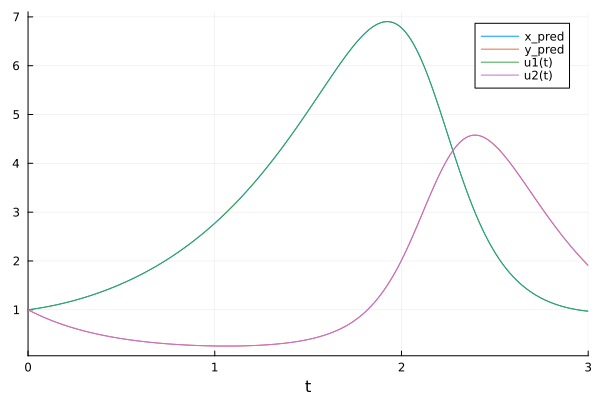

In [17]:
using Plots

phi = pinn.phi
ts = [true_sol.t...;;]
x_pred = phi.x(ts, res.u.x)
y_pred = phi.y(ts, res.u.y)

plot(vec(ts), vec(x_pred), label="x_pred")
plot!(vec(ts), vec(y_pred), label="y_pred")
plot!(true_sol)